# Q1

In this question, we will train a simple energy-based model (EBM) on the MNIST digit dataset.

## Setup

In [1]:
# Import necessary libraries
import random
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST

In [2]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


# Dataset (10 points)

Load the `MNIST` dataset and normalize the images between -1 and 1 as this makes the implementation easier.

In [3]:
# TODO: Define transformations and set the batch size
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x + 0.03 * torch.randn_like(x))
])

transform_eval = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# TODO: Load train and test datasets
trainset = MNIST(root="./data", train=True, download=True, transform=transform_train)
testset = MNIST(root="./data", train=False, download=True, transform=transform_eval)

batch_size = 128

# TODO: Load the train and test loaders
_train_pin = (device == "cuda")
trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=_train_pin,
    drop_last=True
)
testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=_train_pin,
    drop_last=False
)

# Langevin Dynamics (20 points)

The Langevin dynamics in our case starts with a randomly initialized $x_0$ and then uses the information about the landscape of the energy function
(i.e., the gradient) to seek for new $x$, that is:
$$x_{t+1} = x_{t} + \alpha \nabla_{x_t}\text{LogSumExp} \left[f_{\theta} (x) \right] + \sigma \cdot \epsilon$$

where $\alpha, \sigma > 0$ and $\epsilon \sim \mathcal{N}(0, I)$. The Langevin dynamics could be seen as the stochastic gradient descent in the observable space with a small Gaussian noise added at each step.

Our goal is to run the Langevin dynamics for $\eta$ iterations with the steps size $\alpha$ and the noise level equal $\sigma$.

In [4]:
def energy_gradient(model, x):
    # TODO: Set model to evaluation mode
    was_training = model.training
    model.eval()

    # TDOO: Copy the original data and make it require gradients
    x_req = x.detach().clone()
    x_req.requires_grad_(True)

    # TODO: Calculate the gradient
    with torch.enable_grad():
        out = model(x_req)
        if out.dim() == 1:
            energy = out
        elif out.size(-1) == 1:
            energy = out.squeeze(-1)
        else:
            energy = torch.logsumexp(out, dim=-1)
        grad = torch.autograd.grad(energy.sum(), x_req, create_graph=False, retain_graph=False)[0]

    # TODO: Set model to training mode
    if was_training:
        model.train()
    else:
        model.eval()

    # TODO: Return the gradients
    return grad.detach()

In [5]:
def langevin_dynamics_step(model, x, alpha, sigma):
    # TODO: Calculate gradient w.r.t. x
    grad = energy_gradient(model, x)

    # TODO: Sample epsilon ~ Normal(0, I)
    eps = torch.randn_like(x)

    # TODO: Generatae a new sample
    x_new = x + alpha * grad + sigma * eps
    x_new = torch.clamp(x_new, -0.999, 0.999)

    # TODO: Return the new sample
    return x_new.detach()

# Sampling (15 points)

In [6]:
def sample(model, eta, alpha, sigma):
    # TODO: Sample x0 from uniform [-1, +1]
    try:
        dev = next(model.parameters()).device
    except StopIteration:
        dev = device if isinstance(device, str) else "cpu"

    if hasattr(model, "input_shape"):
        shape = tuple(getattr(model, "input_shape"))
    elif hasattr(model, "img_shape"):
        shape = tuple(getattr(model, "img_shape"))
    else:
        shape = (1, 28, 28)

    bs = globals().get("batch_size", 1)
    x = torch.empty((bs,) + shape, device=dev).uniform_(-1.0, 1.0)

    # TODO: Run Langevin Dynamics η times
    for _ in range(int(eta)):
        x = langevin_dynamics_step(model, x, alpha, sigma)

    # TODO: Return the result
    return x

# Loss (15 points)

We can evaluate our model using the following objective:

$$\mathcal{L} = \mathcal{L}_\text{clf}(\theta) + \mathcal{L}_\text{gen}(\theta)$$

Where $\mathcal{L}_\text{clf}(\theta)$ is the cross-entropy loss and $\mathcal{L}_\text{gen}(\theta)$ is an approximation to the log-marginal distribution over images (for example the LogSumExp loss).

In [7]:
def loss_function(model, eta, alpha, sigma, x, y_pred, y_true):
    # TODO: Calculate the discriminative loss: the cross-entropy
    clf_loss_vec = F.cross_entropy(y_pred, y_true, reduction="none")

    # TODO: Calculate the generative loss: E(x) - E(x_sample)
    if y_pred.dim() == 1:
        e_pos = y_pred
    elif y_pred.size(-1) == 1:
        e_pos = y_pred.squeeze(-1)
    else:
        e_pos = torch.logsumexp(y_pred, dim=-1)

    x_neg = torch.empty_like(x).uniform_(-1.0, 1.0)
    for _ in range(int(eta)):
        x_neg = langevin_dynamics_step(model, x_neg, alpha, sigma)

    y_neg = model(x_neg)
    if y_neg.dim() == 1:
        e_neg = y_neg
    elif y_neg.size(-1) == 1:
        e_neg = y_neg.squeeze(-1)
    else:
        e_neg = torch.logsumexp(y_neg, dim=-1)

    gen_loss_vec = -(e_pos - e_neg)

    # TODO: Return the total loss
    return (clf_loss_vec + gen_loss_vec).mean()

# Neural Network (10 points)

Define the neural network that specifies the energy function.
The inputs should be images and the outputs must be the classes.
Don't forget to use appropriate activation functions!

In [8]:
class EnergyNet(nn.Module):
    def __init__(self, D=28*28, M=768, K=10):
        super().__init__()
        self.input_shape = (1, 28, 28)
        self.D = int(D)
        self.net = nn.Sequential(
            nn.Linear(self.D, M), nn.ELU(),
            nn.Linear(M, M), nn.ELU(),
            nn.Linear(M, M), nn.ELU(),
            nn.Linear(M, M), nn.ELU(),
            nn.Linear(M, K)
        )

    def forward(self, x, y=None):
        if x.dim() == 4:
            x = x.view(x.size(0), -1)
        elif x.dim() == 3:
            x = x.view(x.size(0), -1)
        elif x.dim() == 2:
            pass
        else:
            x = x.view(1, -1)

        logits = self.net(x)

        if y is None:
            return logits

        if y.dtype in (torch.int8, torch.int16, torch.int32, torch.int64) and y.dim() == 1:
            return logits.gather(1, y.view(-1, 1)).squeeze(1)
        return (logits * y).sum(dim=-1)

# Visualize (15 points)

Create the following functions to be able to visualize real and generated images.

In [9]:
def visualize_real(loader):
    batch = next(iter(loader))
    if isinstance(batch, (list, tuple)) and len(batch) >= 2:
        x, y = batch[0], batch[1]
    else:
        x, y = batch, None

    n = min(16, x.size(0))
    rows = int(np.floor(np.sqrt(n)))
    rows = max(rows, 1)
    cols = int(np.ceil(n / rows))

    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(n):
        img = x[i]
        if img.dim() == 3 and img.size(0) == 1:
            img = img.squeeze(0)
        img = (img * 0.5 + 0.5).clamp(0.0, 1.0).detach().cpu().numpy()

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap="gray")
        if y is not None:
            plt.title(str(int(y[i].item())))
        plt.axis("off")
    plt.tight_layout()
    plt.show()


def visualize_generated(model, eta, alpha, sigma, loader, restarts=4, temperature=1.5):
    try:
        dev = next(model.parameters()).device
    except StopIteration:
        dev = device if isinstance(device, str) else "cpu"

    bs = getattr(loader, "batch_size", None)
    if bs is None:
        batch = next(iter(loader))
        if isinstance(batch, (list, tuple)) and len(batch) >= 1:
            bs = batch[0].size(0)
        else:
            bs = batch.size(0)

    if hasattr(model, "input_shape"):
        shape = tuple(getattr(model, "input_shape"))
    elif hasattr(model, "img_shape"):
        shape = tuple(getattr(model, "img_shape"))
    else:
        shape = (1, 28, 28)

    n = min(16, int(bs))
    per_restart = int(np.ceil(n / max(1, int(restarts))))
    xs = []

    for _ in range(int(restarts)):
        x = torch.empty((per_restart,) + shape, device=dev).uniform_(-1.0, 1.0)
        for t in range(int(eta)):
            frac = 1.0 - (t / max(1, int(eta) - 1))
            sigma_t = sigma * (0.25 + 0.75 * frac)
            x = langevin_dynamics_step(model, x, alpha, sigma_t)
        xs.append(x)

    x = torch.cat(xs, dim=0)[:n]

    with torch.no_grad():
        logits = model(x)
        if logits.dim() > 1 and logits.size(-1) > 1:
            probs = torch.softmax(logits / float(temperature), dim=-1)
            preds = torch.multinomial(probs, 1).squeeze(1).detach().cpu()
        else:
            preds = None

    rows = int(np.floor(np.sqrt(n)))
    rows = max(rows, 1)
    cols = int(np.ceil(n / rows))

    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(n):
        img = x[i]
        if img.dim() == 3 and img.size(0) == 1:
            img = img.squeeze(0)
        img = (img * 0.5 + 0.5).clamp(0.0, 1.0).detach().cpu().numpy()

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap="gray")
        if preds is not None:
            plt.title(str(int(preds[i].item())))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Training (15 points)

Fill in the evaluation and training functions. Make sure you track the loss and plot it to analyze possible issues.

In [10]:
def eval_ebm(model, loader, eta, alpha, sigma):
    # TODO: Evaluate the model on the loader
    was_training = model.training
    model.eval()

    total_nll = 0.0
    total_ce = 0.0
    total_gen = 0.0
    total_n = 0

    with torch.no_grad():
        for batch in loader:
            x, y = batch[0], batch[1]
            try:
                dev = next(model.parameters()).device
            except StopIteration:
                dev = x.device

            x = x.to(dev, non_blocking=True)
            y = y.to(dev, non_blocking=True)

            y_pred = model(x)
            loss = loss_function(model, eta, alpha, sigma, x, y_pred, y)

            clf = F.cross_entropy(y_pred, y, reduction="mean")
            gen = loss - clf

            pred = y_pred.argmax(dim=1)
            ce = (pred != y).float().mean()

            bs = x.size(0)
            total_nll += float(loss.item()) * bs
            total_gen += float(gen.item()) * bs
            total_ce += float(ce.item()) * bs
            total_n += bs

    if was_training:
        model.train()
    else:
        model.eval()

    denom = max(total_n, 1)
    return total_nll / denom, total_ce / denom, total_gen / denom


def train_ebm(model, optimizer, loader, epochs, eta, alpha, sigma, scheduler=None):
    # TODO: Train the model on the loader
    from tqdm.auto import tqdm

    train_losses_step = []
    train_losses_epoch = []
    eval_nll_epoch = []
    eval_ce_epoch = []
    eval_gen_epoch = []

    try:
        steps_per_epoch = len(loader)
    except TypeError:
        steps_per_epoch = None

    total_steps = int(epochs) * steps_per_epoch if steps_per_epoch is not None else None
    pbar = tqdm(total=total_steps, dynamic_ncols=True)

    eval_loader = None
    for name in ("valloader", "validloader", "val_loader", "testloader", "test_loader"):
        if name in globals():
            eval_loader = globals()[name]
            break
    if eval_loader is None:
        eval_loader = loader

    best_state = None
    best_eval_nll = float("inf")

    for epoch in range(int(epochs)):
        model.train()

        total_loss = 0.0
        total_n = 0

        if total_steps is None:
            pbar.reset(total=0)

        for i, batch in enumerate(loader):
            x, y = batch[0], batch[1]
            try:
                dev = next(model.parameters()).device
            except StopIteration:
                dev = x.device

            x = x.to(dev, non_blocking=True)
            y = y.to(dev, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            y_pred = model(x)
            loss = loss_function(model, eta, alpha, sigma, x, y_pred, y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            bs = x.size(0)
            li = float(loss.item())
            train_losses_step.append(li)
            total_loss += li * bs
            total_n += bs

            avg = total_loss / max(total_n, 1)
            lr = optimizer.param_groups[0]["lr"] if optimizer.param_groups else None

            if steps_per_epoch is None:
                pbar.set_description(f"epoch {epoch + 1}/{int(epochs)} step {i + 1}")
            else:
                pbar.set_description(f"epoch {epoch + 1}/{int(epochs)} [{i + 1}/{steps_per_epoch}]")

            if lr is None:
                pbar.set_postfix(loss=li, avg=avg)
            else:
                pbar.set_postfix(loss=li, avg=avg, lr=lr)

            pbar.update(1)

        if scheduler is not None:
            scheduler.step()

        epoch_avg = total_loss / max(total_n, 1)
        train_losses_epoch.append(epoch_avg)

        eval_nll, eval_ce, eval_gen = eval_ebm(model, eval_loader, eta, alpha, sigma)
        eval_nll_epoch.append(eval_nll)
        eval_ce_epoch.append(eval_ce)
        eval_gen_epoch.append(eval_gen)

        if eval_nll < best_eval_nll:
            best_eval_nll = eval_nll
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        print(f"[epoch {epoch + 1:03d}/{int(epochs):03d}] val_nll={eval_nll:.6f} val_ce={eval_ce:.6f} val_gen_nll={eval_gen:.6f}")
        visualize_generated(model, eta, alpha, sigma, eval_loader)

    pbar.close()

    if best_state is not None:
        model.load_state_dict(best_state)

    plt.figure()
    plt.plot(train_losses_epoch)
    plt.plot(eval_nll_epoch)
    plt.xlabel("epoch")
    plt.ylabel("nll")
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(eval_ce_epoch)
    plt.xlabel("epoch")
    plt.ylabel("ce")
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(eval_gen_epoch)
    plt.xlabel("epoch")
    plt.ylabel("gen_nll")
    plt.tight_layout()
    plt.show()

    return train_losses_step, train_losses_epoch

Now define the optimizer and train your model.

  0%|          | 0/14040 [00:00<?, ?it/s]

[epoch 001/030] val_nll=0.553268 val_ce=0.199200 val_gen_nll=-0.157846


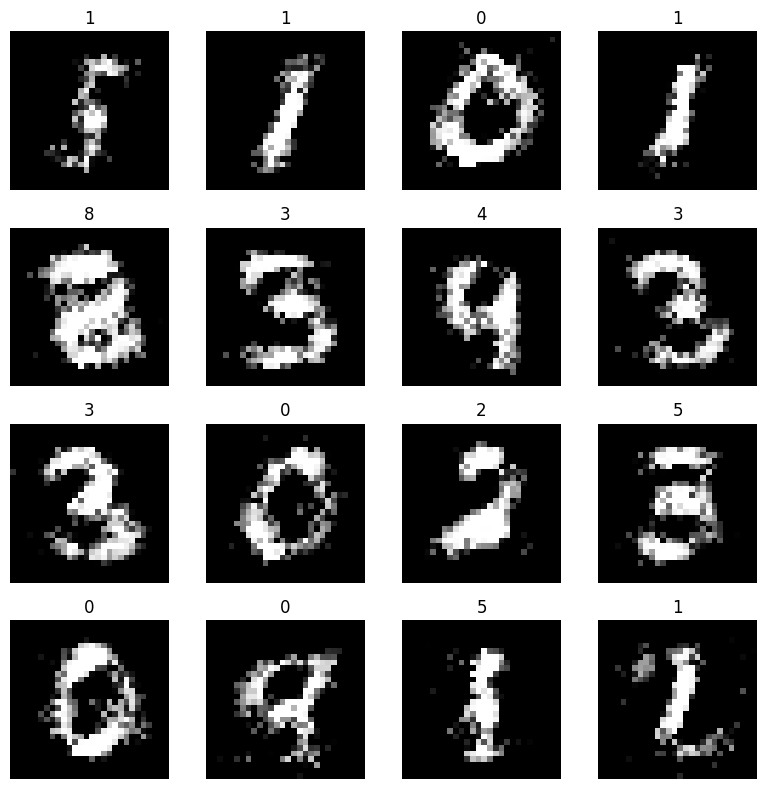

[epoch 002/030] val_nll=4.916395 val_ce=0.139100 val_gen_nll=4.428283


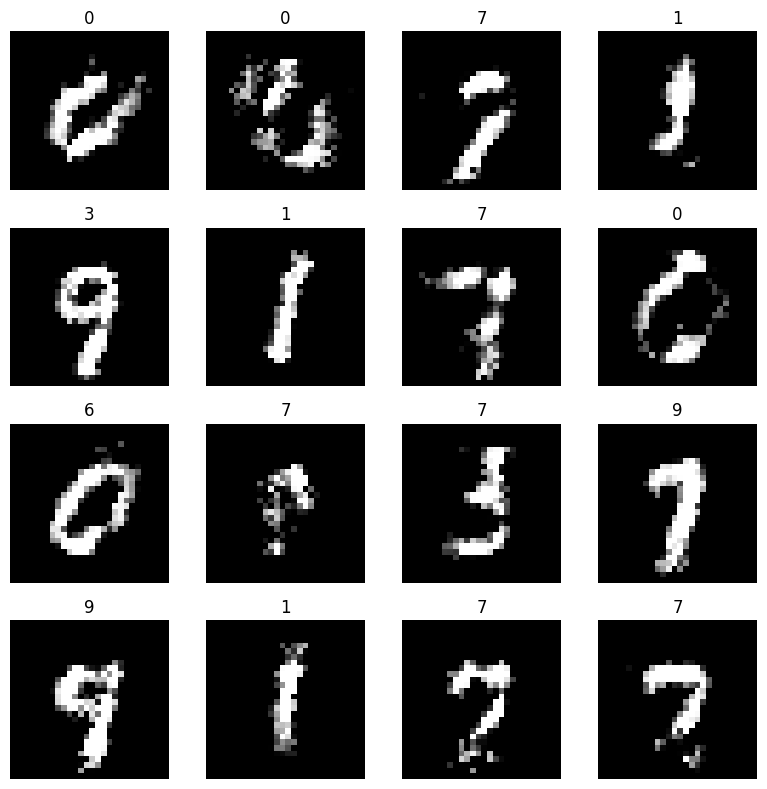

[epoch 003/030] val_nll=0.172496 val_ce=0.124500 val_gen_nll=-0.233749


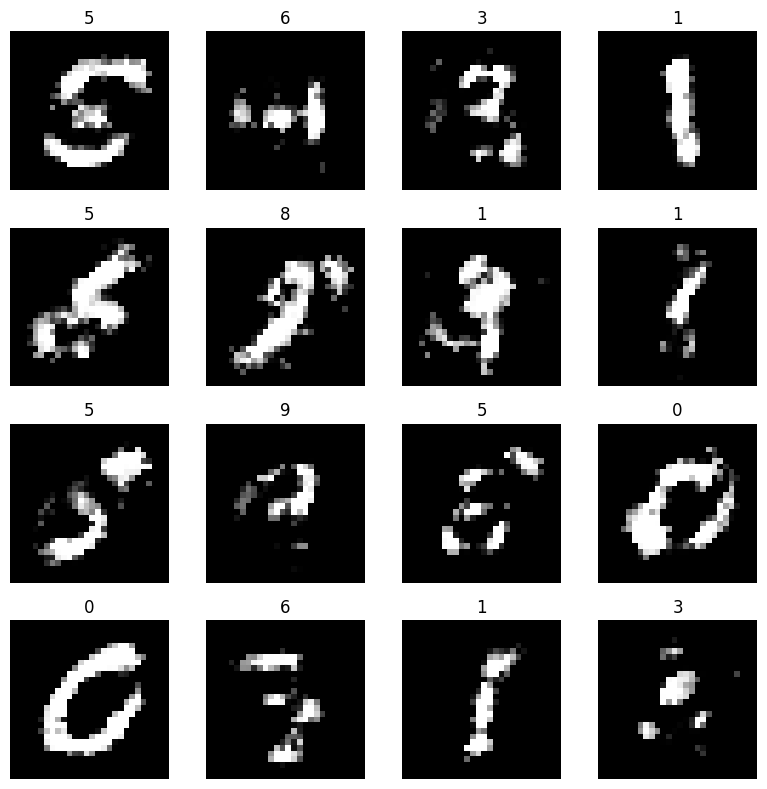

[epoch 004/030] val_nll=16.335719 val_ce=0.579600 val_gen_nll=12.205797


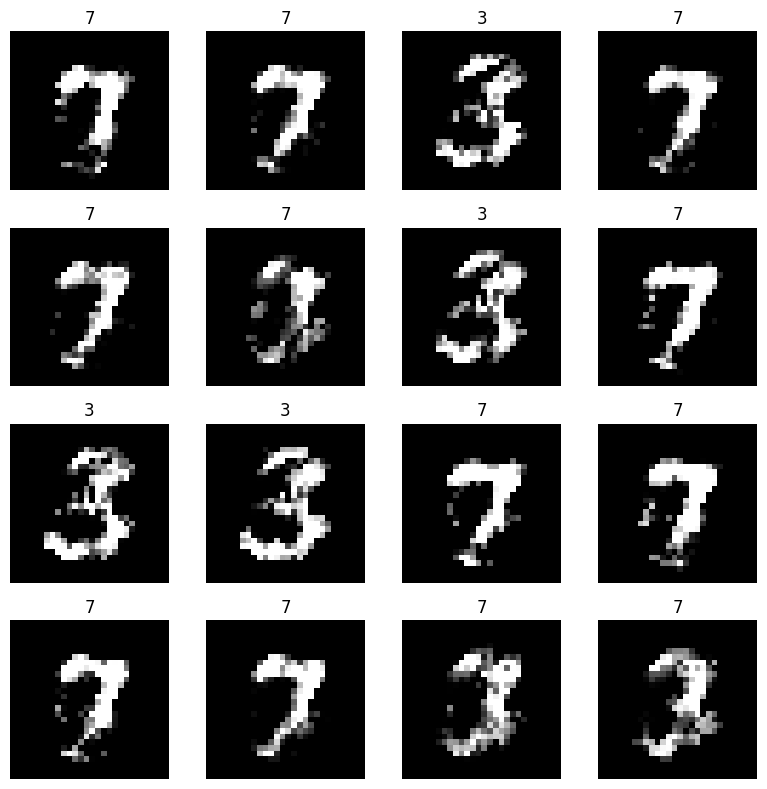

[epoch 005/030] val_nll=30.877716 val_ce=0.671800 val_gen_nll=21.645338


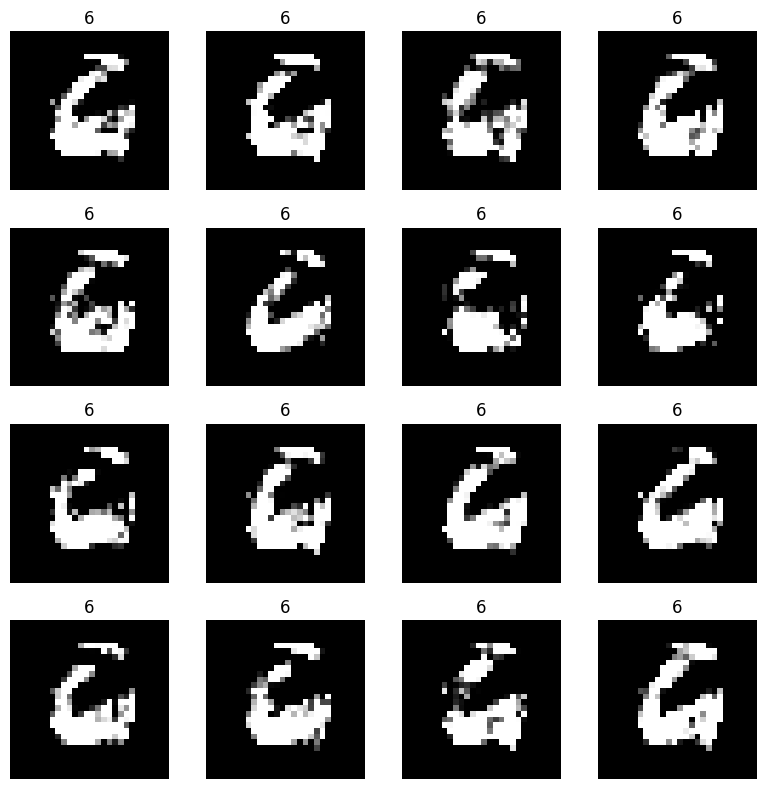

[epoch 006/030] val_nll=-12.671289 val_ce=0.213000 val_gen_nll=-13.319722


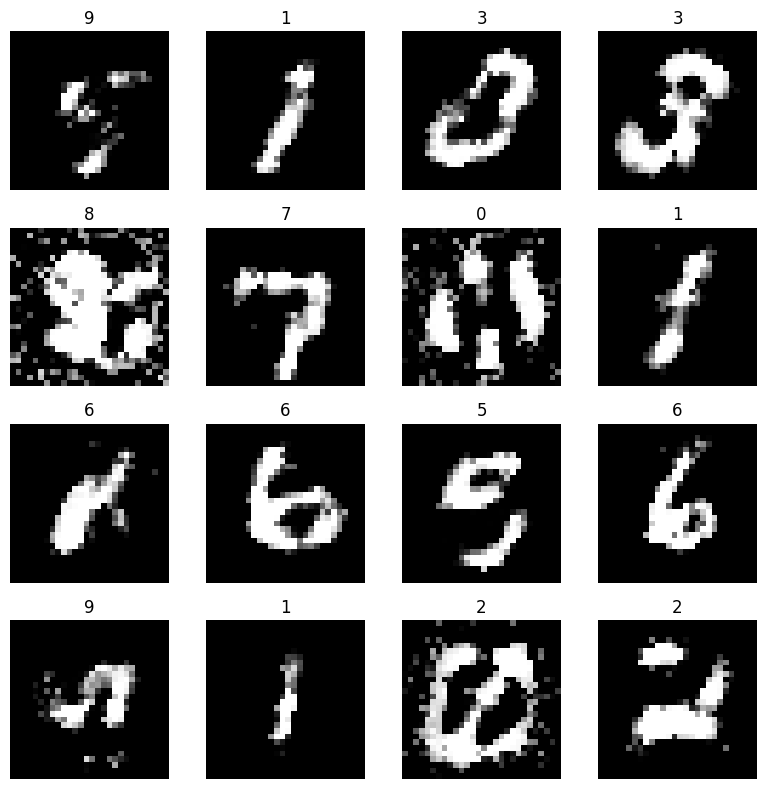

[epoch 007/030] val_nll=6.311186 val_ce=0.406600 val_gen_nll=4.509672


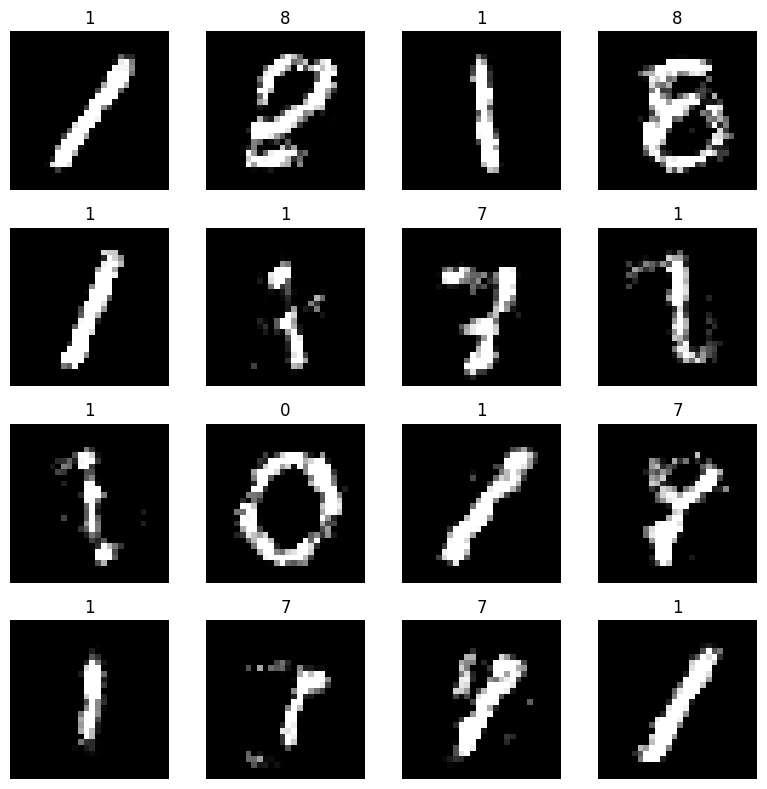

[epoch 008/030] val_nll=11.336719 val_ce=0.607600 val_gen_nll=6.513569


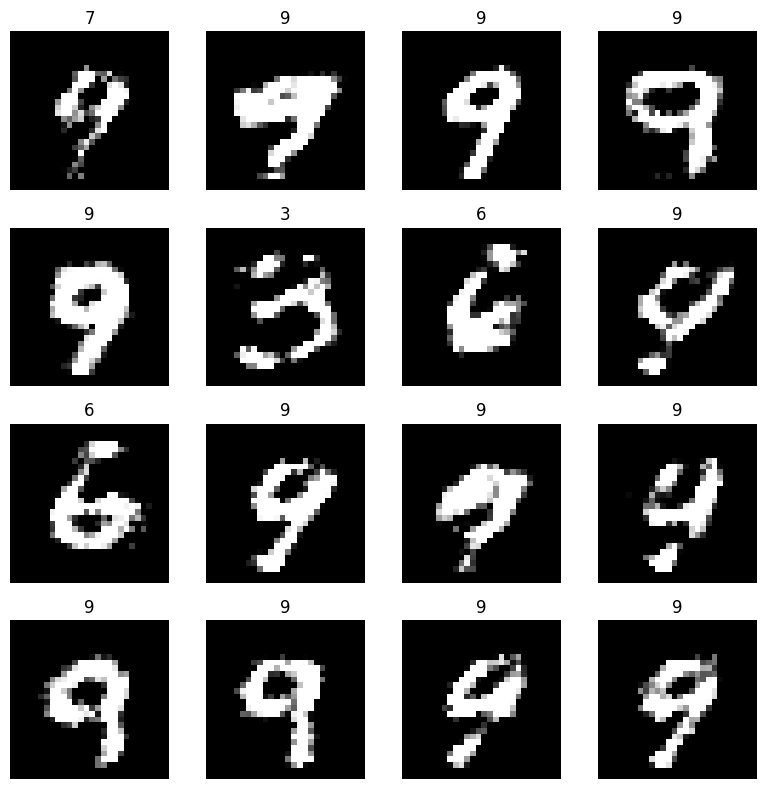

[epoch 009/030] val_nll=0.064462 val_ce=0.115700 val_gen_nll=-0.331233


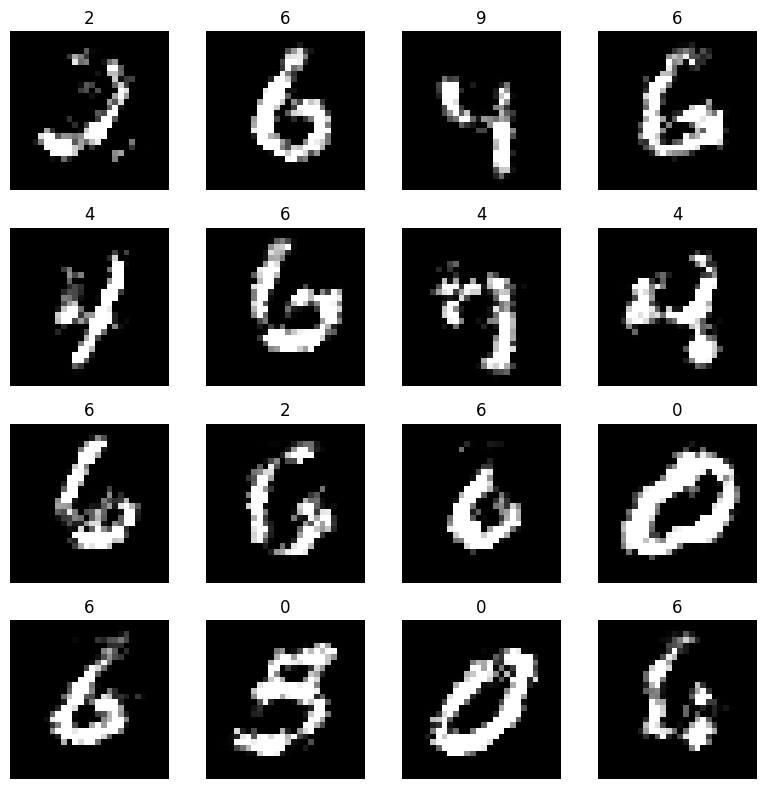

[epoch 010/030] val_nll=-1.112680 val_ce=0.087200 val_gen_nll=-1.403827


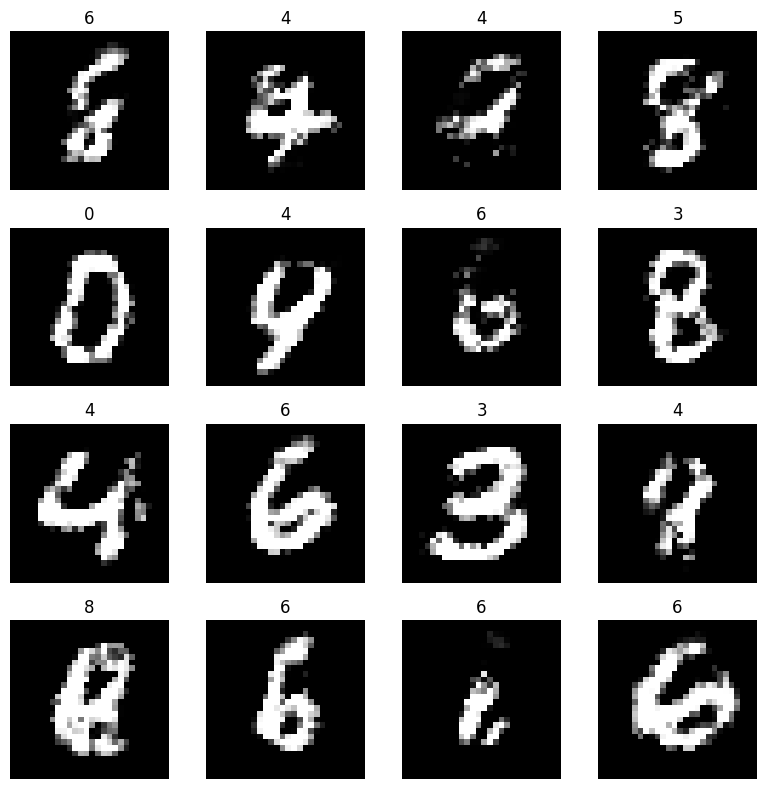

[epoch 011/030] val_nll=-0.194730 val_ce=0.073300 val_gen_nll=-0.454535


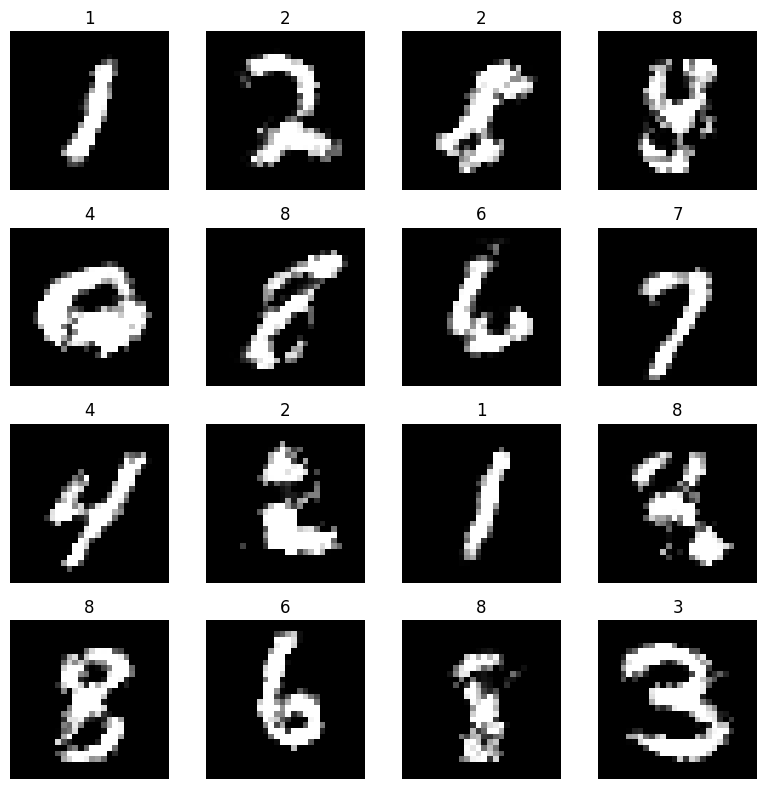

[epoch 012/030] val_nll=2.393655 val_ce=0.083200 val_gen_nll=2.109881


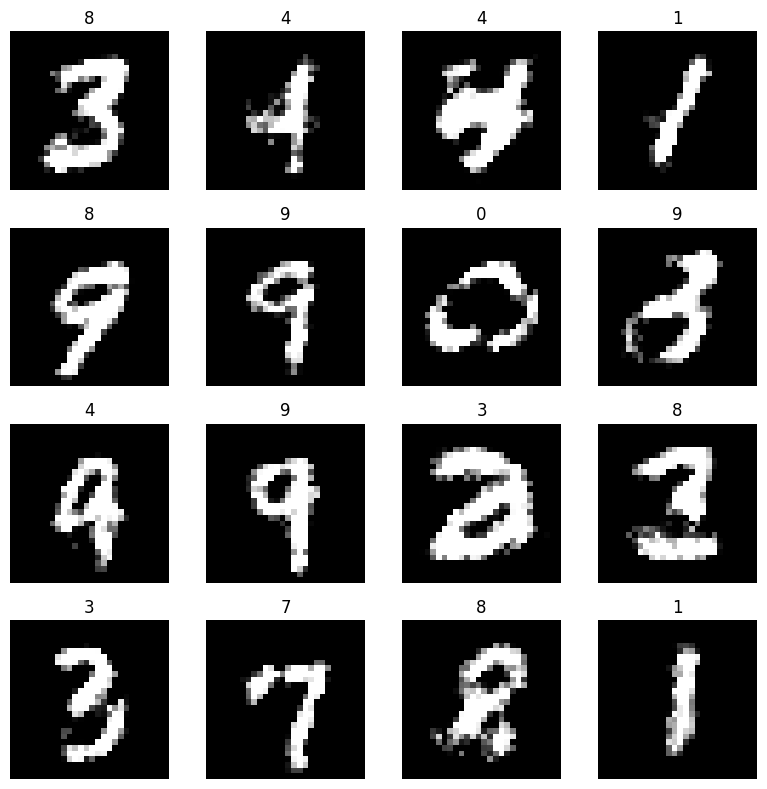

[epoch 013/030] val_nll=2.388594 val_ce=0.070400 val_gen_nll=2.143488


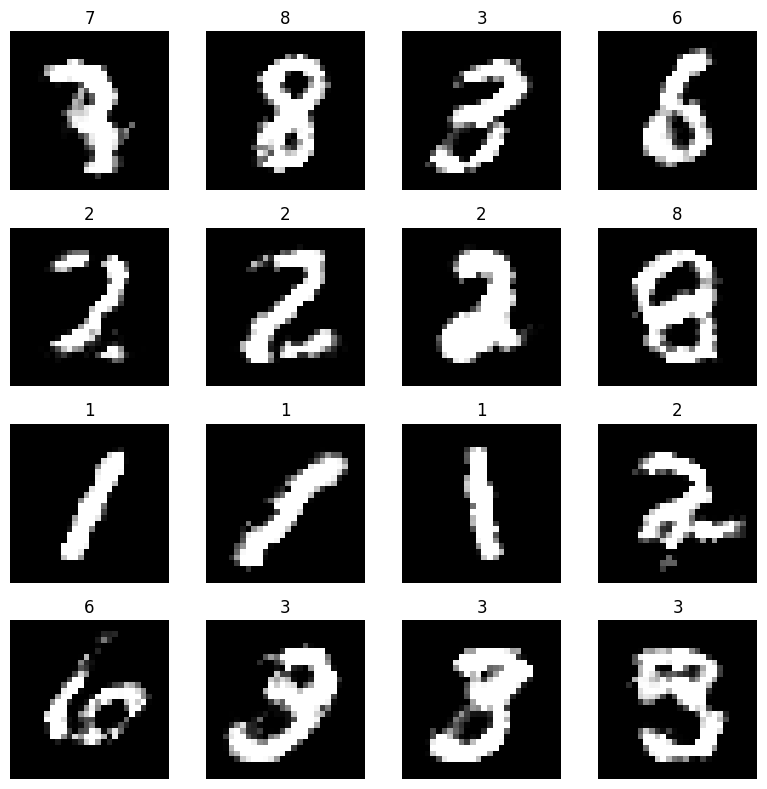

[epoch 014/030] val_nll=-4.540754 val_ce=0.051900 val_gen_nll=-4.708494


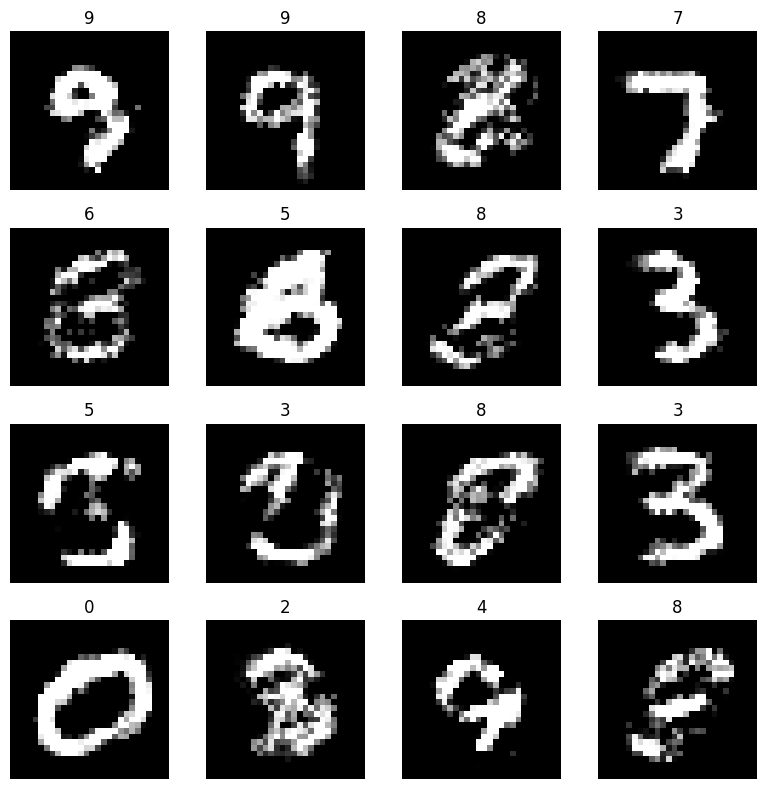

[epoch 015/030] val_nll=0.725929 val_ce=0.053100 val_gen_nll=0.541593


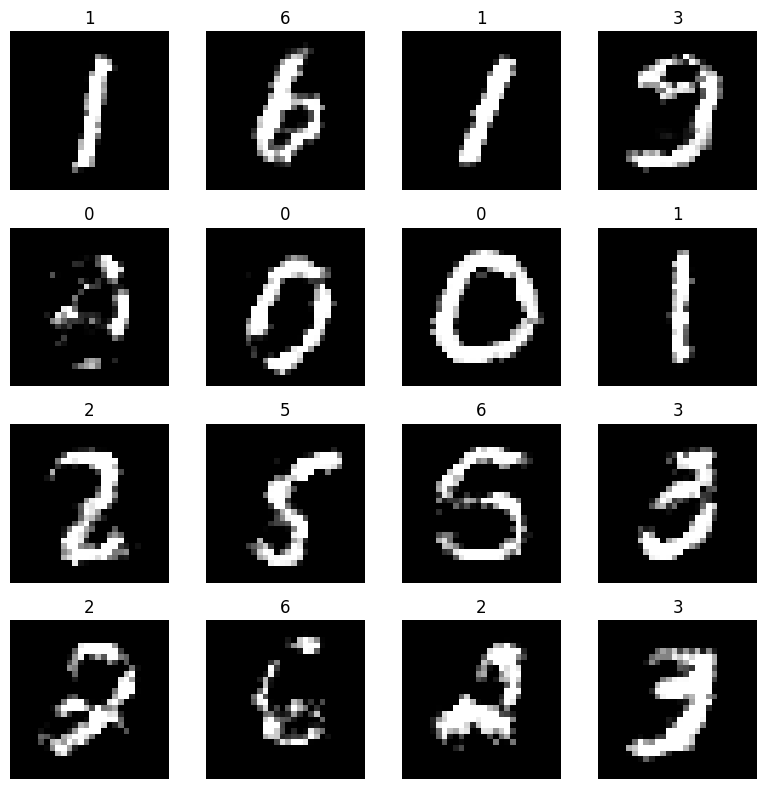

[epoch 016/030] val_nll=1.653801 val_ce=0.115500 val_gen_nll=1.291294


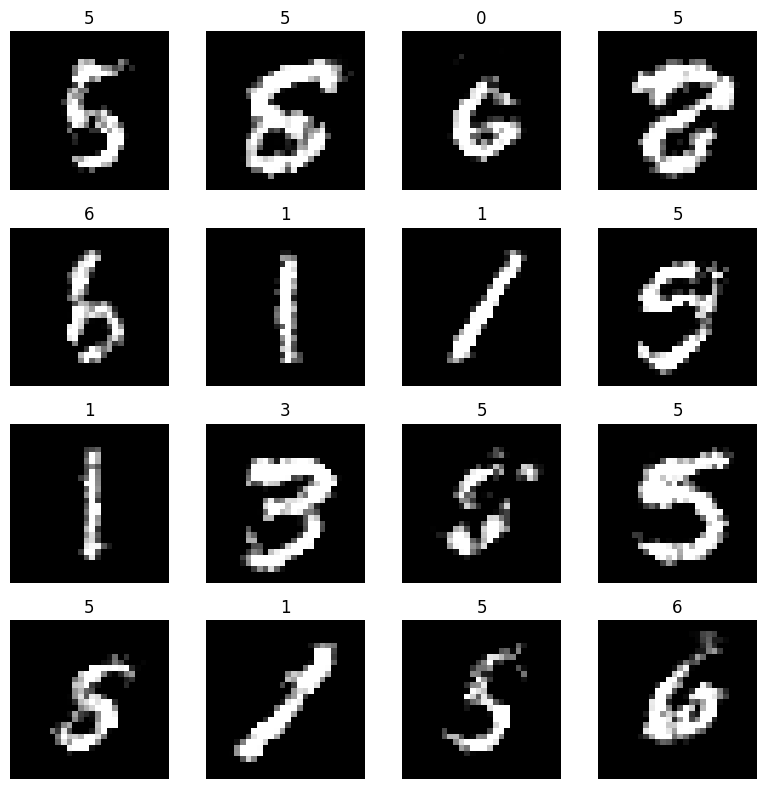

[epoch 017/030] val_nll=0.559420 val_ce=0.064400 val_gen_nll=0.338976


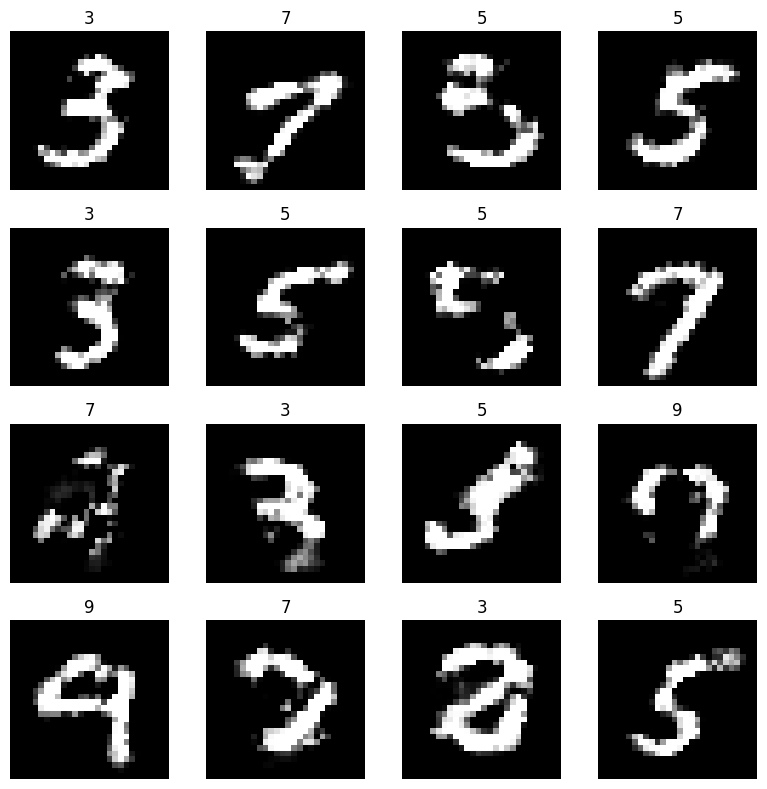

[epoch 018/030] val_nll=-1.127171 val_ce=0.055600 val_gen_nll=-1.327309


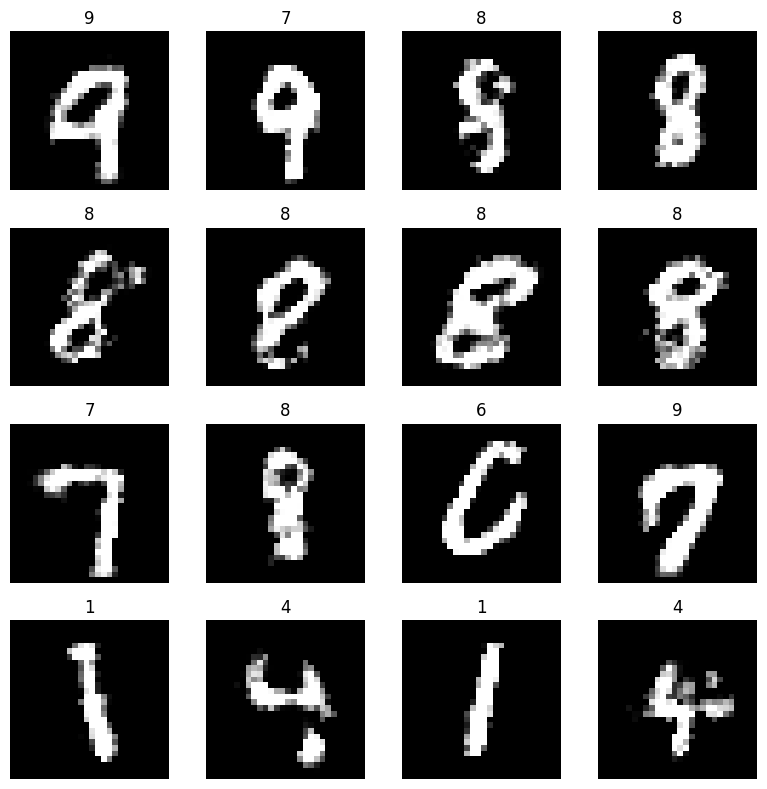

[epoch 019/030] val_nll=1.332349 val_ce=0.060900 val_gen_nll=1.123588


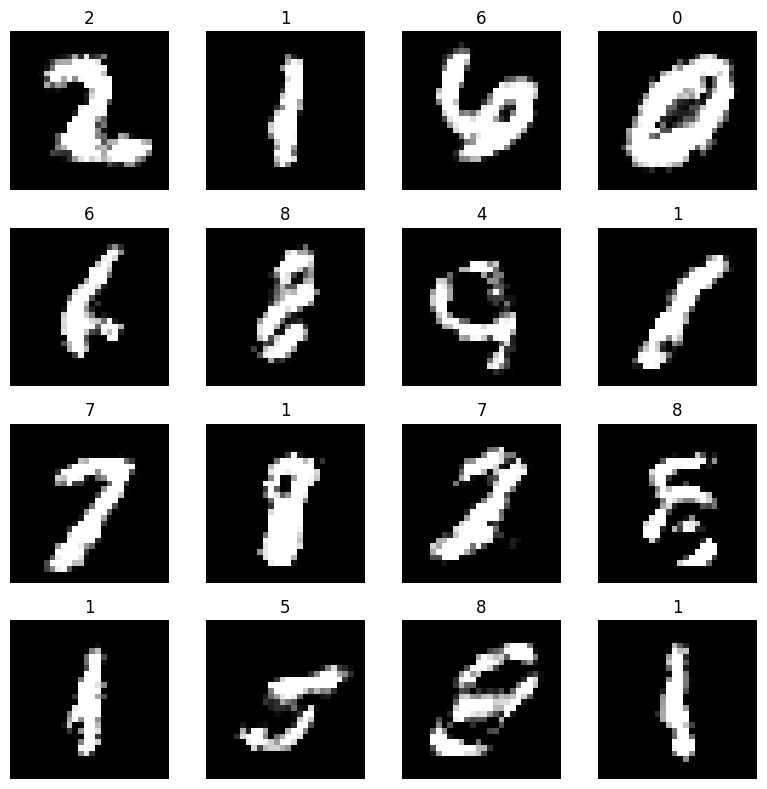

[epoch 020/030] val_nll=1.465845 val_ce=0.041100 val_gen_nll=1.300309


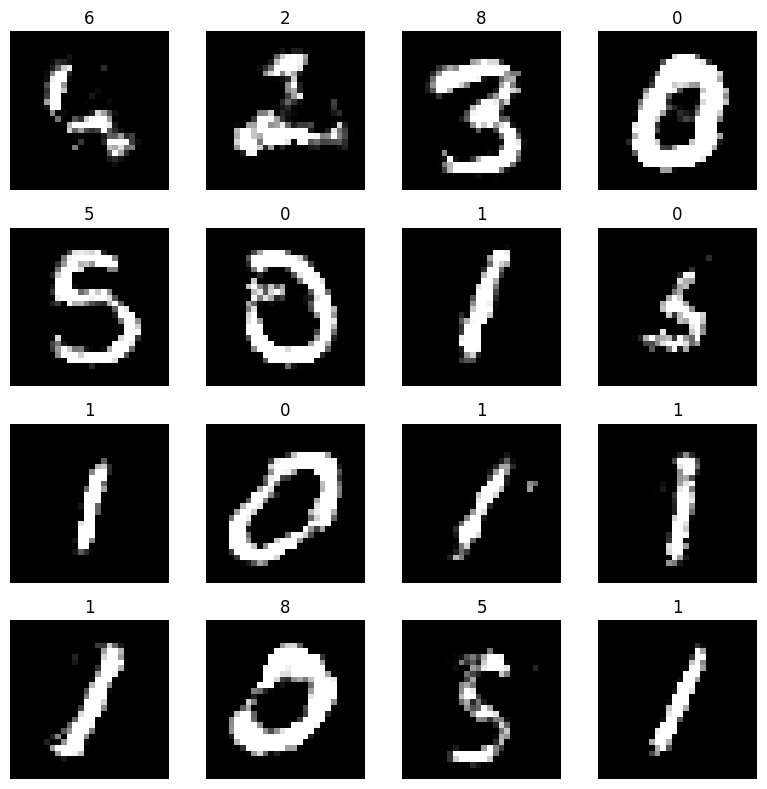

[epoch 021/030] val_nll=0.523346 val_ce=0.051000 val_gen_nll=0.359834


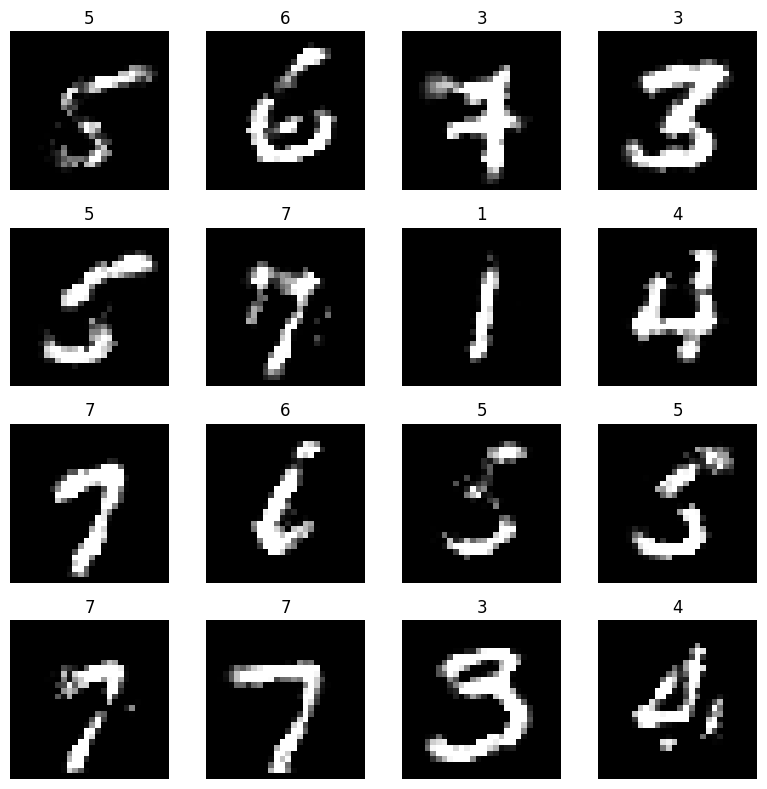

[epoch 022/030] val_nll=0.096236 val_ce=0.034600 val_gen_nll=-0.029870


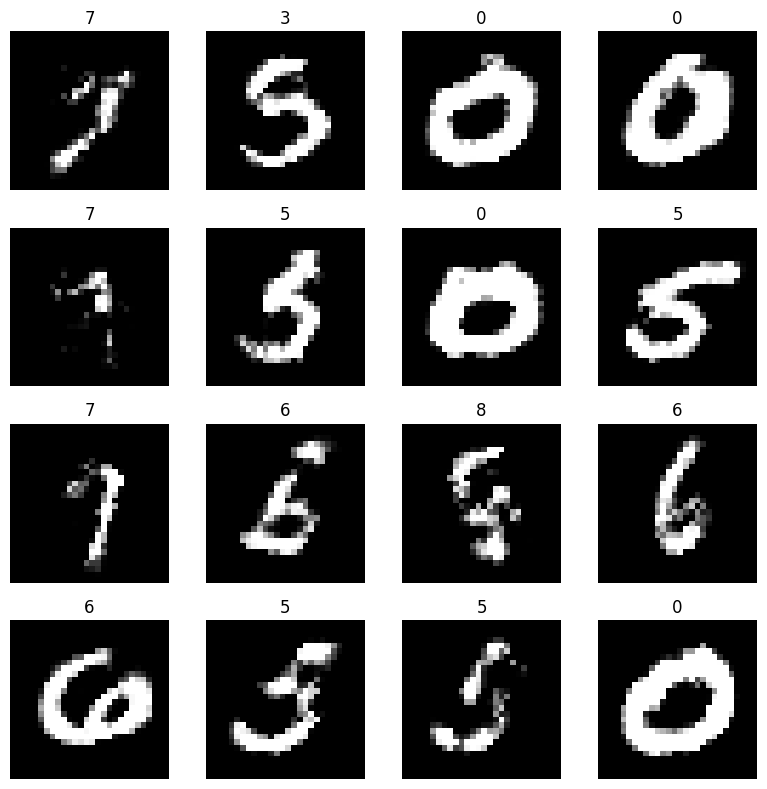

[epoch 023/030] val_nll=-0.481114 val_ce=0.033900 val_gen_nll=-0.599051


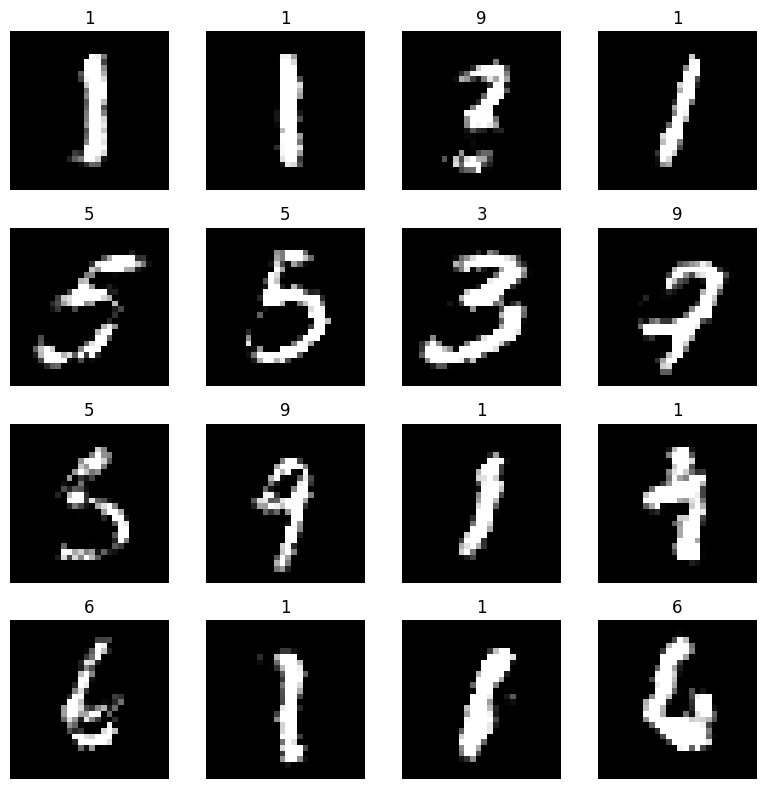

[epoch 024/030] val_nll=1.076043 val_ce=0.080500 val_gen_nll=0.797951


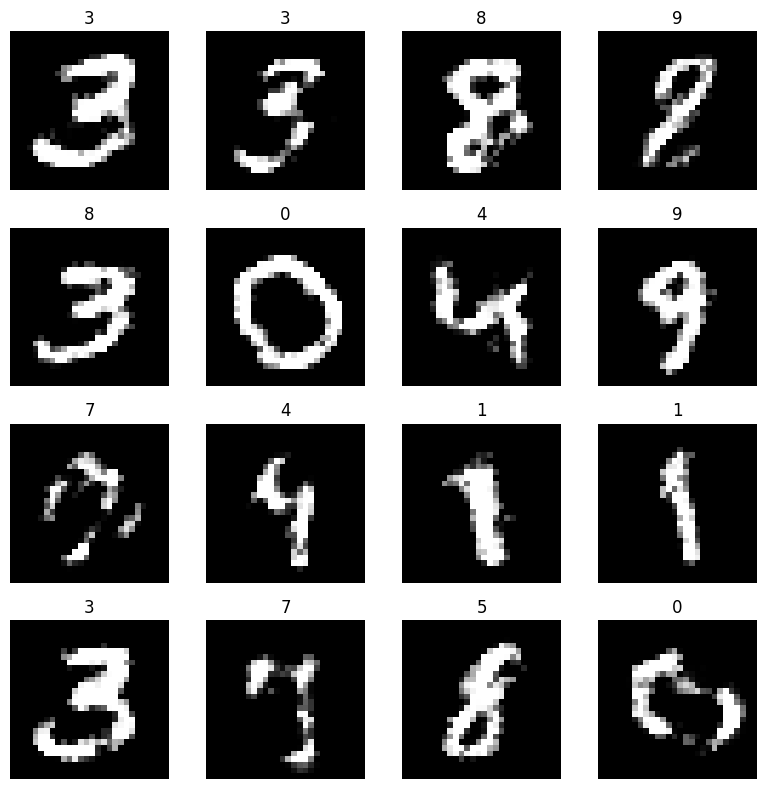

[epoch 025/030] val_nll=-1.179703 val_ce=0.035200 val_gen_nll=-1.310639


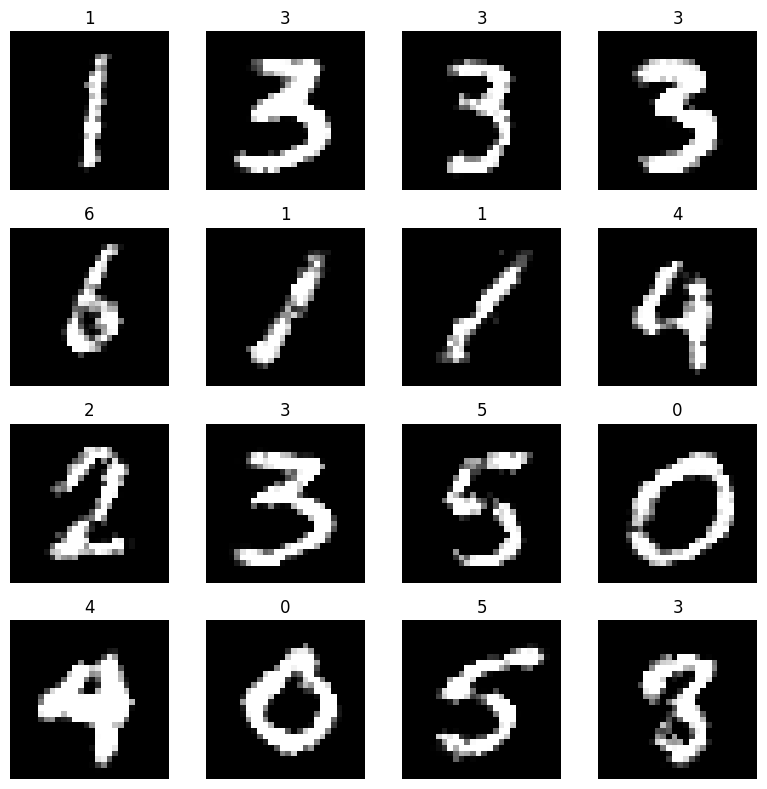

[epoch 026/030] val_nll=-2.938044 val_ce=0.032600 val_gen_nll=-3.048221


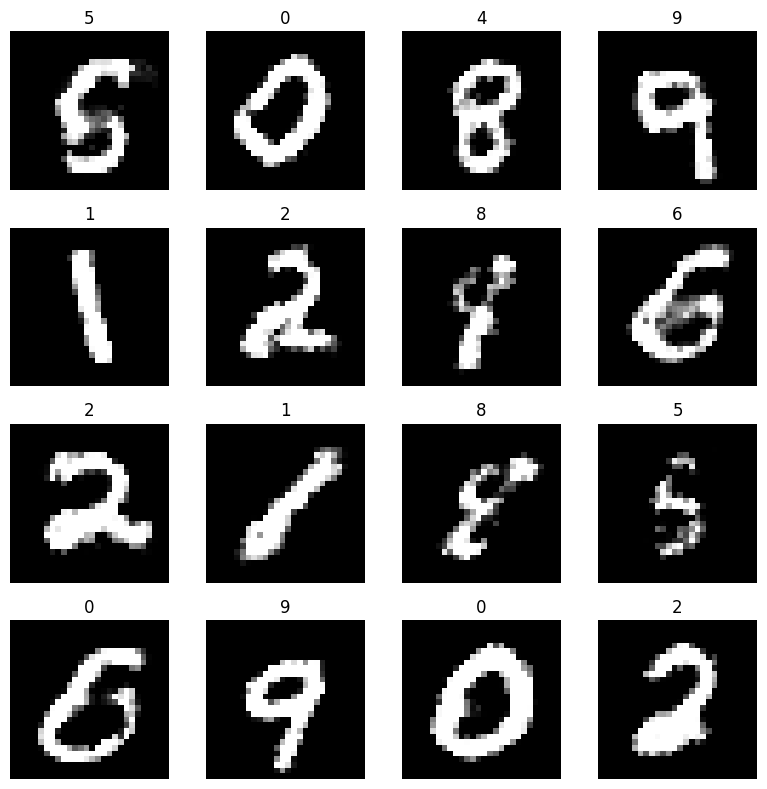

[epoch 027/030] val_nll=-0.780486 val_ce=0.039400 val_gen_nll=-0.931871


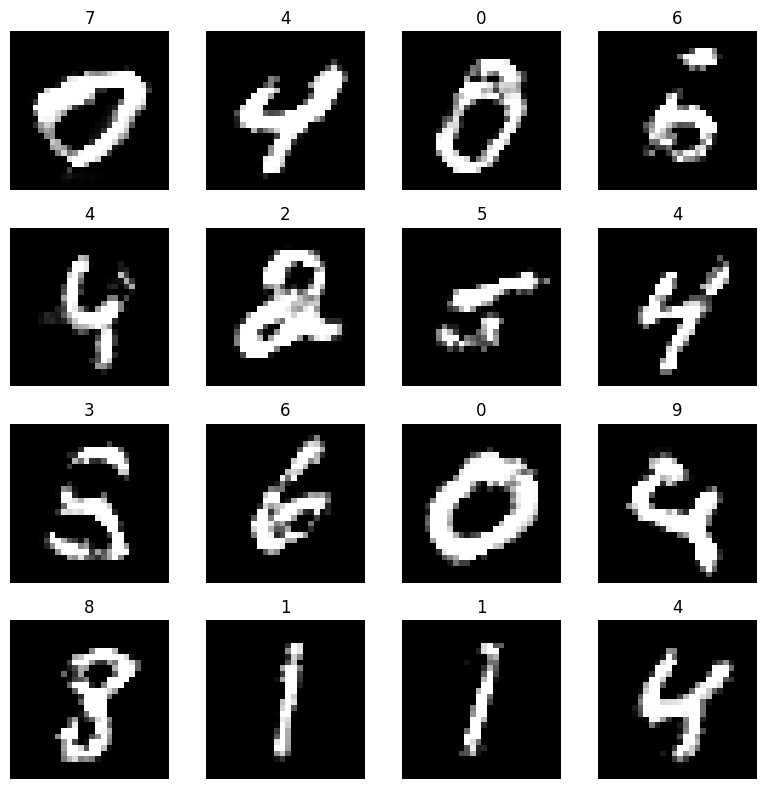

[epoch 028/030] val_nll=0.666660 val_ce=0.122500 val_gen_nll=0.082397


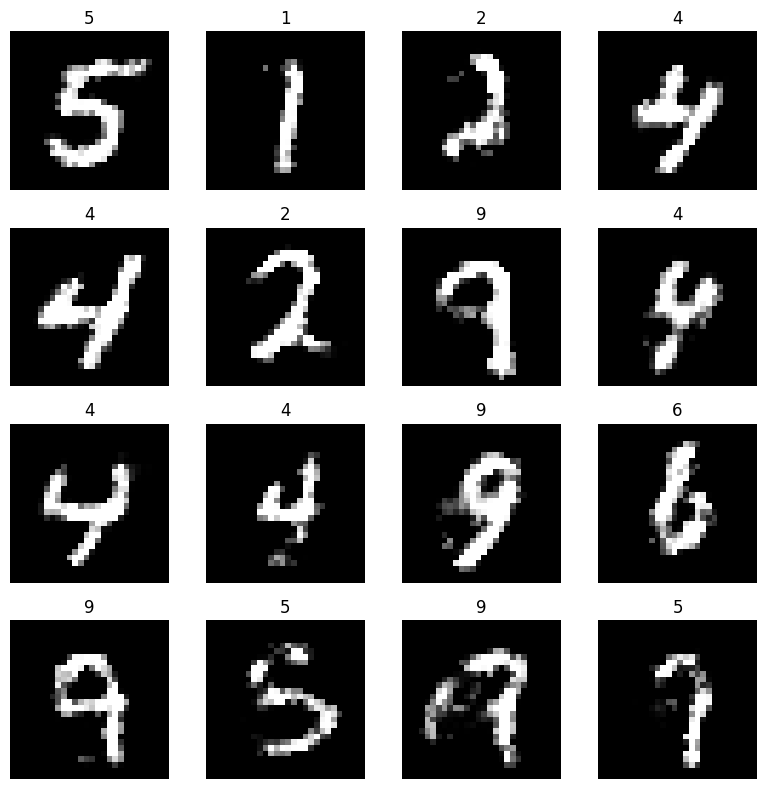

[epoch 029/030] val_nll=0.113199 val_ce=0.031400 val_gen_nll=0.007786


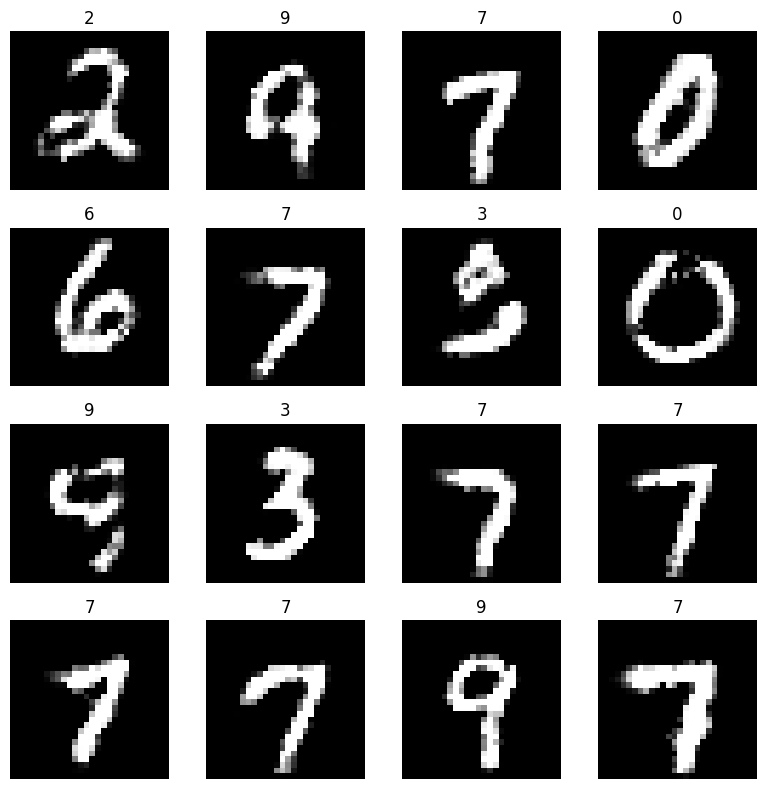

[epoch 030/030] val_nll=5.004532 val_ce=0.076000 val_gen_nll=4.611775


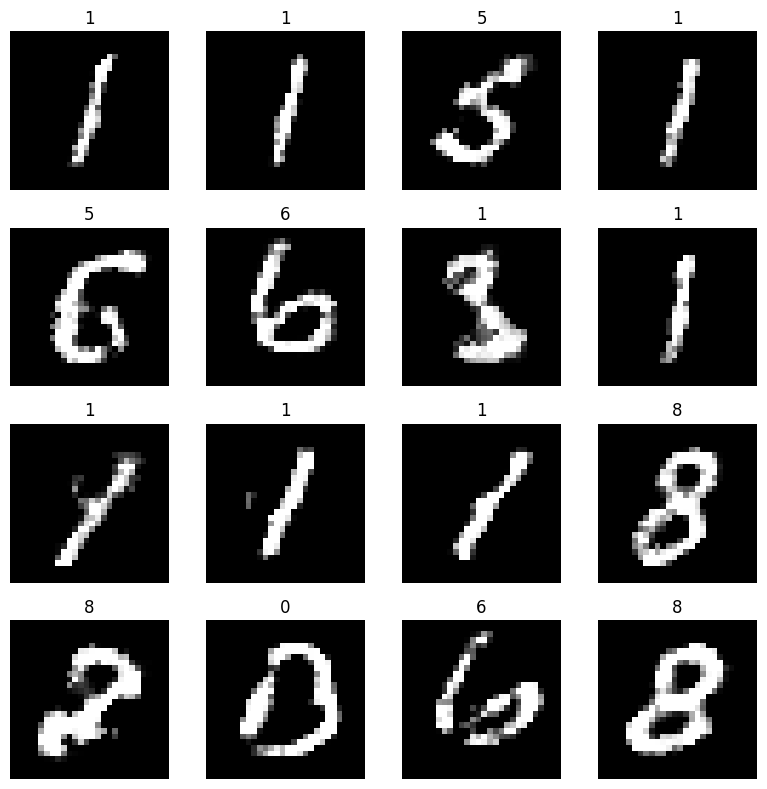

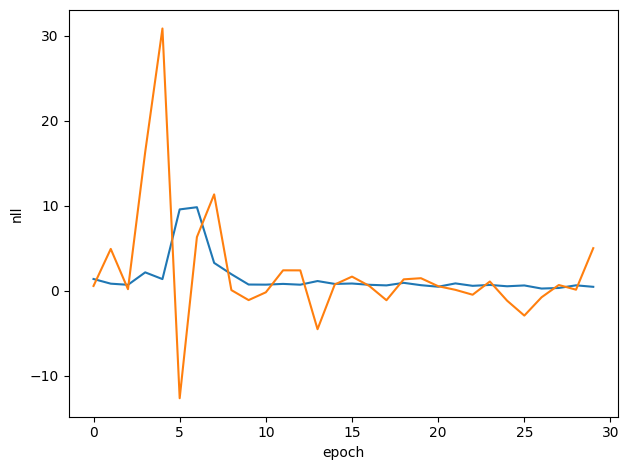

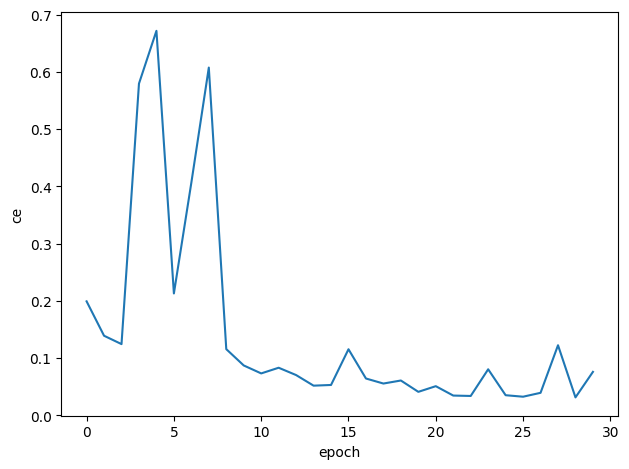

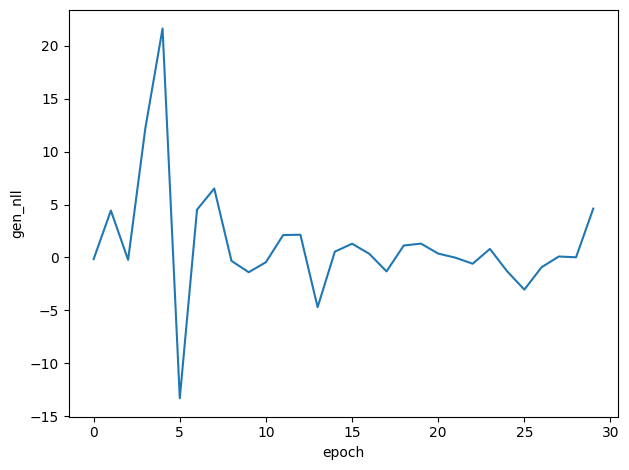

In [11]:
# TODO: Train your EBM
model = EnergyNet().to(device)

eta = 50
alpha = 0.75
sigma = 0.08
epochs = 30

from torch.optim.lr_scheduler import StepLR

optimizer = optim.Adamax(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

train_losses_step, train_losses_epoch = train_ebm(model, optimizer, trainloader, epochs, eta, alpha, sigma)

Plot the training curve.

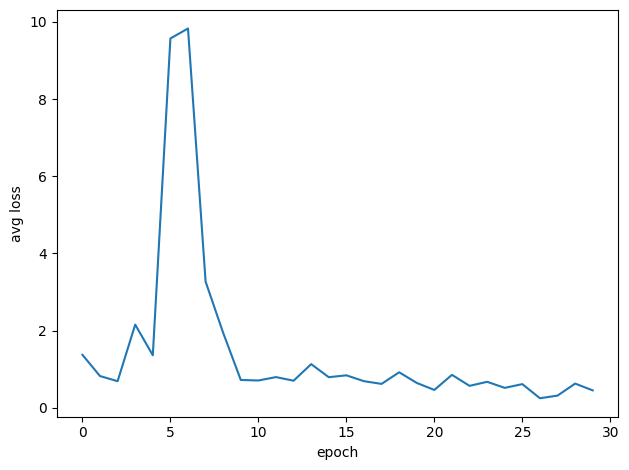

In [12]:
# TODO: Plot loss over epochs
plt.figure()
plt.plot(train_losses_epoch)
plt.xlabel("epoch")
plt.ylabel("avg loss")
plt.tight_layout()
plt.show()

Now visualize generated samples. (You can visualize images every few epochs to see the evolution of your network)

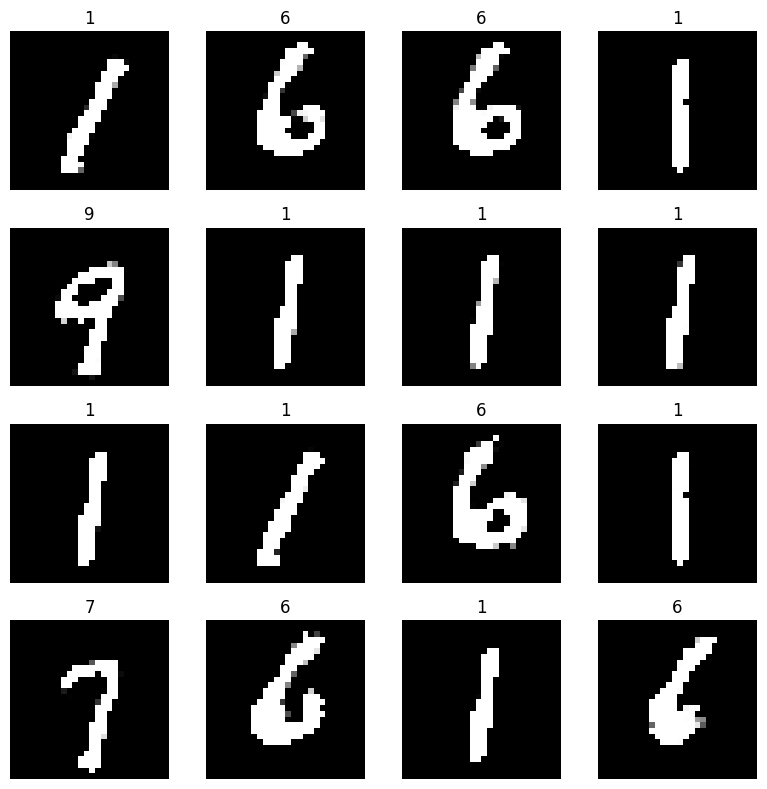

In [26]:
# TODO: Generate and visualize images
visualize_generated(model, 500, alpha, sigma, testloader)

If your resutls aren't great you can tune the hyperparameters to get better results or alternatively you can modify the dataset (resize, ...)to make it easier to learn the energy function.

# Q2: Denoising score matching

## Theory

### Problem 1: Implicit score matching

The objective of score matching is
$$
    \frac{1}{2} \mathbb{E}_{\pi}\bigl\| \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}) - \nabla_\mathbf{x} \log \pi(\mathbf{x}) \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}.
$$

And we have already known one possible solution for this task. It is denoising score matching.

Here our goal is to derive one more way to solve the initial score matching problem. It is called **implicit score matching**.

Let consider 1-d case ($x \in \mathbb{R}$).
Prove that
$$
\frac{1}{2} \mathbb{E}_{\pi}\bigl\| s_{\boldsymbol{\theta}}(x) - \nabla_x \log \pi(x) \bigr\|^2_2 = \mathbb{E}_{\pi}\left[ \frac{1}{2}s^2_{\boldsymbol{\theta}}(x) + \nabla_{x} s_{\boldsymbol{\theta}}(x) \right] + \text{const}.
$$

- **Question:** Why is the expression at the right hand side better than the left one? Because the left-hand side contains the unknown quantity $\nabla_x \log \pi(x)$ (the data score), which we cannot evaluate from samples alone.  
After integration by parts, the right-hand side becomes
$$
\mathbb{E}_{\pi}\!\left[\frac12 s_\theta(x)^2 + \partial_x s_\theta(x)\right] + \text{const},
$$
which depends only on $x \sim \pi$ and the model $s_\theta$ (and its derivative). The remaining term marked “const” does not depend on $\theta$, so minimizing the RHS is equivalent to minimizing the original objective, but is now *tractable from samples*.

- **Question:** Why do we not use this expression instead of denoising score matching? In $d$ dimensions the RHS contains the divergence term
$$
\nabla \cdot s_\theta(x)=\mathrm{tr}\big(\nabla_x s_\theta(x)\big)=\sum_{i=1}^d \frac{\partial s_{\theta,i}(x)}{\partial x_i}.
$$
Computing $\mathrm{tr}(\nabla_x s_\theta(x))$ for a neural network is very expensive: it requires the diagonal of the Jacobian, and a straightforward implementation effectively needs $d$ separate backward passes (one per coordinate) to get all $\partial s_{\theta,i}(x)/\partial x_i$. This becomes prohibitively slow and memory-heavy in high dimensions (e.g., images), so in practice we use DSM which avoids this term.





- **Question:** Why do we consider only 1-d case? In 1D, $\nabla \cdot s_\theta(x)$ reduces to a single derivative $\partial_x s_\theta(x)$, so it is cheap to compute.  
In $d$ dimensions it becomes $\mathrm{tr}(\nabla_x s_\theta(x))$, which is costly because a naive computation needs $d$ backward passes, so the multidimensional version is much more computationally demanding.



### Problem 2: Conditioned reverse distribution for NCSN

The distribution $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0)$ plays the crucial role in the DDPM.

Find the parameters of this Normal distribution for the NCSN Markov chain $\mathbf{x}_t = \mathbf{x}_0 + \sigma_t \cdot \boldsymbol{\epsilon}$.

**Note:** in this case the mean should be the convex combination of $\mathbf{x}_t$ and $\mathbf{x}_0$ (this differs from the DDPM Markov chain).

For NCSN we have the marginal noising model
$$
q(\mathbf{x}_t \mid \mathbf{x}_0)=\mathcal{N}(\mathbf{x}_0,\ \sigma_t^2 \mathbf{I}).
$$
To make it a Markov chain with these marginals, use the forward transition
$$
q(\mathbf{x}_t \mid \mathbf{x}_{t-1})=\mathcal{N}\!\left(\mathbf{x}_{t-1},\ (\sigma_t^2-\sigma_{t-1}^2)\mathbf{I}\right),
\qquad \sigma_t^2>\sigma_{t-1}^2.
$$
Then the conditioned reverse distribution is Gaussian:
$$
q(\mathbf{x}_{t-1}\mid \mathbf{x}_t,\mathbf{x}_0)=\mathcal{N}\!\left(\tilde{\boldsymbol{\mu}}_t(\mathbf{x}_t,\mathbf{x}_0),\ \tilde{\sigma}_t^2 \mathbf{I}\right),
$$
with
$$
\tilde{\boldsymbol{\mu}}_t(\mathbf{x}_t,\mathbf{x}_0)
=\frac{\sigma_{t-1}^2}{\sigma_t^2}\,\mathbf{x}_t
+\frac{\sigma_t^2-\sigma_{t-1}^2}{\sigma_t^2}\,\mathbf{x}_0
=\mathbf{x}_0+\frac{\sigma_{t-1}^2}{\sigma_t^2}\,(\mathbf{x}_t-\mathbf{x}_0),
$$
and
$$
\tilde{\sigma}_t^2=\frac{\sigma_{t-1}^2(\sigma_t^2-\sigma_{t-1}^2)}{\sigma_t^2}.
$$

Note the mean is a convex combination of $\mathbf{x}_t$ and $\mathbf{x}_0$ since the coefficients sum to $1$.


```
your solution
```

In [1]:
import numpy as np
from typing import Tuple, List
import math

import torch
import torch.nn as nn
import torch.utils.data as data
from torch.nn import functional as F

if torch.cuda.is_available():
    DEVICE = "cuda"
    print('GPU found :)')
else:
    DEVICE = "cpu"
    print('GPU not found :(')

GPU found :)


# NOTE: Don't change this part

In [2]:
from typing import Dict, List, Literal, Optional, Tuple
from collections import defaultdict
from IPython.display import clear_output

import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import LRScheduler

import torchvision
from torchvision.utils import make_grid
from sklearn.datasets import make_moons
from contextlib import nullcontext



TICKS_FONT_SIZE = 12
LEGEND_FONT_SIZE = 12
LABEL_FONT_SIZE = 14
TITLE_FONT_SIZE = 16

TOY_DATASETS = ["moons"]
IMAGE_DATASETS = ["mnist", "cifar10"]

def prepare_images(
    train_data: np.ndarray,
    test_data: np.ndarray,
    flatten: bool = False,
    binarize: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    if binarize:
        train_data = (train_data > 128).astype("int64")
        test_data = (test_data > 128).astype("int64")
    else:
        train_data = train_data / 255.0
        test_data = test_data / 255.0

    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    if flatten:
        train_data = train_data.reshape(len(train_data.shape[0]), -1)
        test_data = test_data.reshape(len(train_data.shape[0]), -1)

    return train_data, test_data

def load_MNIST(with_targets: bool = False) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:
    train_dataset = torchvision.datasets.MNIST(root="./", train=True, download=True)
    test_dataset = torchvision.datasets.MNIST(root="./", train=False, download=True)

    transform = torchvision.transforms.Resize((14, 14))
    train_data = torch.stack([transform(img.unsqueeze(0)) for img in train_dataset.data]).numpy().transpose(0, 2, 3, 1)
    test_data = torch.stack([transform(img.unsqueeze(0)) for img in test_dataset.data]).numpy().transpose(0, 2, 3, 1)

    if with_targets:
        train_labels, test_labels = train_dataset.targets.numpy(), test_dataset.targets.numpy()
        return train_data, train_labels, test_data, test_labels

    return train_data, None, test_data, None


def load_CIFAR10(with_targets: bool = False) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:
    train_dataset = torchvision.datasets.CIFAR10(root="./", train=True, download=True)
    test_dataset = torchvision.datasets.CIFAR10(root="./", train=False, download=True)
    train_data, test_data = train_dataset.data, test_dataset.data

    if with_targets:
        train_labels, test_labels = (
            train_dataset.targets.numpy(),
            test_dataset.targets.numpy(),
        )
        return train_data, train_labels, test_data, test_labels

    return train_data, None, test_data, None

def load_moons(
    size: int,
    with_targets: bool
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:
    data, labels = make_moons(n_samples=size, noise=0.1)
    split = int(0.8 * size)
    train_data, test_data = data[:split], data[split:]

    if with_targets:
        train_labels, test_labels = labels[:split], labels[split:]
        return train_data, train_labels, test_data, test_labels

    return train_data, None, test_data, None


def _load_dataset(
    name: Literal["mnist", "cifar10", "moons"],
    size: Optional[int] = None,
    with_targets: bool = False,
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:
    if name == "mnist":
        return load_MNIST(with_targets=with_targets)
    elif name == "cifar10":
        return load_CIFAR10(with_targets=with_targets)
    elif name == "moons":
        if size is None:
            raise ValueError("Size must be specifed for 'moons' dataset!")
        return load_moons(size=size, with_targets=with_targets)
    else:
        raise ValueError("The argument name must have the values 'mnist', 'cifar10' or 'moons'!")


def load_dataset(
    name: str,
    size: Optional[int] = None,
    flatten: bool = False,
    binarize: bool = True,
    with_targets: bool = False
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:

    train_data, train_labels, test_data, test_labels = _load_dataset(
        name, size=size,
        with_targets=with_targets
    )
    train_data = train_data.astype("float32")
    test_data = test_data.astype("float32")

    if name in IMAGE_DATASETS:
        train_data, test_data = prepare_images(
            train_data,
            test_data,
            flatten=flatten,
            binarize=binarize
        )

    if with_targets:
        return train_data, train_labels, test_data, test_labels

    return train_data, test_data

class LabeledDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y


def plot_training_curves(
    epochs: int,
    train_losses: Dict[str, List[float]],
    test_losses: Optional[Dict[str, List[float]]],
    logscale_y: bool = False,
    logscale_x: bool = False,
) -> None:
    if test_losses is not None:
        n_test = len(test_losses[list(train_losses.keys())[0]])
        x_test = np.arange(n_test)

    n_train = len(train_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, epochs - 1, n_train)


    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + "_train")

    if test_losses is not None:
        for key, value in test_losses.items():
            plt.plot(x_test, value, label=key + "_test")

    if logscale_y:
        plt.semilogy()

    if logscale_x:
        plt.semilogx()

    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.xlabel("Epoch", fontsize=LABEL_FONT_SIZE)
    plt.ylabel("Loss", fontsize=LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    plt.grid()
    plt.show()


def show_samples(
    samples: np.ndarray | torch.Tensor,
    title: str,
    figsize: Optional[Tuple[int, int]] = None,
    nrow: Optional[int] = None,
    normalize: bool = False
) -> None:
    if isinstance(samples, np.ndarray):
        samples = torch.tensor(samples)
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))

    grid_samples = make_grid(samples, nrow=nrow, normalize=normalize, scale_each=True)
    grid_img = grid_samples.permute(1, 2, 0)

    plt.figure(figsize=(6, 6) if figsize is None else figsize)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.imshow(grid_img)
    plt.axis("off")
    plt.show()


def visualize_images(data: np.ndarray, title: str) -> None:
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    show_samples(images, title)


def visualize_2d_data(
    train_data: np.ndarray,
    test_data: np.ndarray,
    train_labels: Optional[str] = None,
    test_labels: Optional[str] = None,
    s: int = 10
) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.set_title("train", fontsize=TITLE_FONT_SIZE)
    ax1.scatter(train_data[:, 0], train_data[:, 1], s=s, c=train_labels)
    ax1.tick_params(labelsize=LABEL_FONT_SIZE)
    ax2.set_title("test", fontsize=TITLE_FONT_SIZE)
    ax2.scatter(test_data[:, 0], test_data[:, 1], s=s, c=test_labels)
    ax2.tick_params(labelsize=LABEL_FONT_SIZE)
    plt.show()


def visualize_2d_samples(
    data: np.ndarray,
    title: str,
    labels: Optional[str] = None,
    xlabel: str = "x1",
    ylabel: str = "x2",
    s: int = 10
) -> None:
    plt.figure(figsize=(5, 5))
    plt.scatter(data[:, 0], data[:, 1], s=s, c=labels)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=LABEL_FONT_SIZE)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=LABEL_FONT_SIZE)
    plt.show()


def visualize_2d_densities(
    x_grid: np.ndarray,
    y_grid: np.ndarray,
    densities: np.ndarray,
    title: str,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
) -> None:
    densities = densities.reshape([y_grid.shape[0], y_grid.shape[1]])
    plt.figure(figsize=(5, 5))
    plt.pcolor(x_grid, y_grid, densities)
    plt.pcolor(x_grid, y_grid, densities)

    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=LABEL_FONT_SIZE)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=LABEL_FONT_SIZE)
    plt.show()



class BaseModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError('Not implemented')

    def loss(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        raise NotImplementedError('Not implemented')

    @torch.no_grad()
    def sample(self, n: int) -> np.ndarray:
        raise NotImplementedError('Not implemented')


def train_epoch(
    epoch: int,
    model: BaseModel,
    train_loader: DataLoader,
    optimizer: Optimizer,
    gradient_clip_val: Optional[float] = None,
    conditional: bool = False,
    device: str = "cpu",
    loss_key: str = "total_loss",
    use_amp: bool = False,
    scaler: Optional[torch.amp.GradScaler] = None,
) -> Dict[str, List[float]]:
    """
    Train the model for one epoch.

    Args:
        epoch: Current epoch number (for logging).
        model: The model to train.
        train_loader: DataLoader for training data.
        optimizer: Optimizer for updating model parameters.
        gradient_clip_val: Optional gradient norm clipping value.
        conditional: Whether the model is conditional (expects (x, y) batches).
        device: Device to train on ("cpu" or "cuda").
        loss_key: Key in the loss dict to use for backpropagation.
        use_amp: Whether to use automatic mixed precision.
        scaler: GradScaler for AMP training.

    Returns:
        Dictionary mapping loss names to lists of per-batch loss values.
    """
    model.train()

    stats: Dict[str, List[float]] = defaultdict(list)
    for batch in tqdm(train_loader, desc=f"Training epoch {epoch}"):
        if conditional:
            x, y = batch
            x, y = x.to(device), y.to(device)
        else:
            x, y = batch.to(device), None
        optimizer.zero_grad()
        ctx = torch.amp.autocast("cuda") if use_amp else nullcontext()
        with ctx:
            losses = model.loss(x, y) if y is not None else model.loss(x)
            loss = losses[loss_key]

        if use_amp:
            scaler.scale(loss).backward()
            if gradient_clip_val is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_val)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if gradient_clip_val is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_val)
            optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())

    return stats


def eval_model(
    epoch: int,
    model: BaseModel,
    data_loader: DataLoader,
    conditional: bool = False,
    device: str = "cpu",
    use_amp: bool = False,
) -> Dict[str, float]:
    """
    Evaluate the model on a dataset.

    Args:
        epoch: Current epoch number (for logging).
        model: The model to evaluate.
        data_loader: DataLoader for evaluation data.
        conditional: Whether the model is conditional (expects (x, y) batches).
        device: Device to evaluate on ("cpu" or "cuda").
        use_amp: Whether to use automatic mixed precision.

    Returns:
        Dictionary mapping loss names to average loss values over the dataset.
    """
    model.eval()
    stats: Dict[str, float] = defaultdict(float)
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Evaluating epoch {epoch}"):
            if conditional:
                x, y = batch
                x, y = x.to(device), y.to(device)
            else:
                x, y = batch.to(device), None
            ctx = torch.amp.autocast("cuda") if use_amp else nullcontext()
            with ctx:
                losses = model.loss(x, y) if y is not None else model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)  # type: ignore
    return stats


def check_samples_is_2d(samples: np.ndarray) -> bool:
    """Check if samples are 2D points (for visualization)."""
    shape = samples.shape
    return len(shape) == 2 and shape[1] == 2


def train_model(
    model: BaseModel,
    train_loader: DataLoader,
    test_loader: DataLoader,
    epochs: int,
    optimizer: Optimizer,
    scheduler: Optional[LRScheduler] = None,
    conditional: bool = False,
    loss_key: str = "total_loss",
    n_samples: int = 100,
    visualize_samples: bool = True,
    logscale_y: bool = False,
    logscale_x: bool = False,
    device: str = "cpu",
):

    train_losses: Dict[str, List[float]] = defaultdict(list)
    test_losses: Dict[str, List[float]] = defaultdict(list)
    model = model.to(device)
    print("Start of the training")

    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(
            epoch=epoch,
            model=model,
            train_loader=train_loader,
            optimizer=optimizer,
            conditional=conditional,
            device=device,
            loss_key=loss_key,
        )
        if scheduler is not None:
            scheduler.step()
        test_loss = eval_model(
            epoch=epoch,
            model=model,
            data_loader=test_loader,
            conditional=conditional,
            device=device,
        )

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])

        epoch_loss = np.mean(train_loss[loss_key])
        if visualize_samples:
            with torch.no_grad():
                samples = model.sample(n_samples)
                if isinstance(samples, torch.Tensor):
                    samples = samples.cpu().detach().numpy()

            clear_output(wait=True)
            title = f"Samples, epoch: {epoch}, {loss_key}: {epoch_loss:.3f}"
            if check_samples_is_2d(samples):
                visualize_2d_samples(samples, title=title)
            else:
                show_samples(samples, title=title)
            plot_training_curves(epoch, train_losses, test_losses, logscale_y, logscale_x)
        else:
            clear_output(wait=True)
            print(f"Epoch: {epoch}, loss: {epoch_loss}")
            plot_training_curves(epoch, train_losses, test_losses, logscale_y, logscale_x)

    print("End of the training")


## Task 2: Denoising score matching for 2D data

In this task you will implement the denoising score matching model to the 2D moons dataset.

Let's take a look at dataset samples.

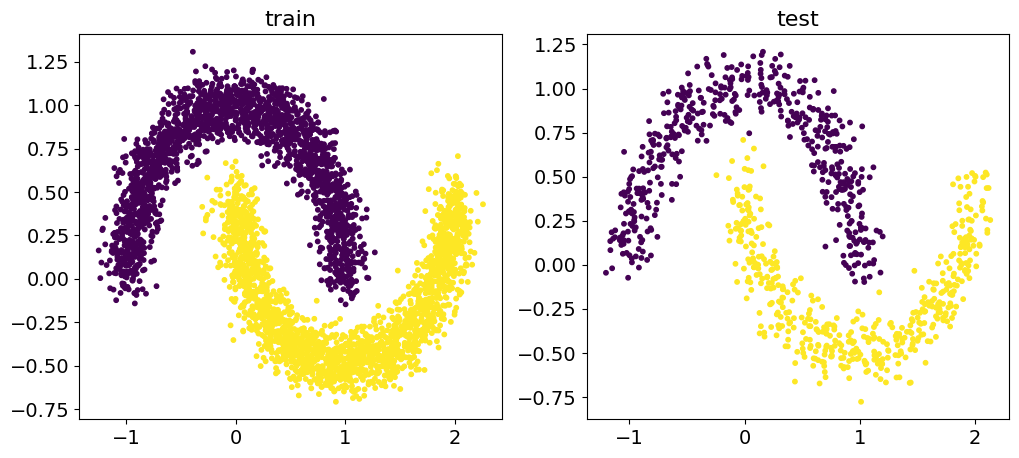

In [3]:
COUNT = 5000

train_data, train_labels, test_data, test_labels = load_dataset('moons', size=COUNT, with_targets=True)
visualize_2d_data(train_data, test_data, train_labels, test_labels)

Let recall the theory of denoising score matching.

The idea is the following. We define the score function
$$
    \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}) = \nabla_{\mathbf{x}}\log p(\mathbf{x}| \boldsymbol{\theta}).
$$

Then we minimize the Fisher divergence to obtain the score function:
$$
    D_F(\pi, p) = \frac{1}{2}\mathbb{E}_{\pi}\bigl\| \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}) - \nabla_{\mathbf{x}} \log \pi(\mathbf{x}) \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}
$$.

If we had the score function, we could use the Langevin dynamics to sample from our model:
$$
    \mathbf{x}_{l + 1} = \mathbf{x}_l + \frac{\eta}{2} \cdot \nabla_{\mathbf{x}_l} \log p(\mathbf{x}_l | \boldsymbol{\theta}) + \sqrt{\eta} \cdot \boldsymbol{\epsilon}, \quad \boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I}).
$$

However, Fisher divergence is intractable and we use the noising procedure to get noised samples $\mathbf{x}_{\sigma} = \mathbf{x} + \sigma \cdot \boldsymbol{\epsilon}$.

Minimizing the Fisher divergence for the noisy samples is equivalent to the following objective:
$$
\mathbb{E}_{q(\mathbf{x}_{\sigma})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma}(\mathbf{x}_{\sigma}) - \nabla_{\mathbf{x}_{\sigma}} \log q(\mathbf{x}_{\sigma}) \bigr\|^2_2 = \mathbb{E}_{\pi(\mathbf{x})} \mathbb{E}_{q(\mathbf{x}_{\sigma} | \mathbf{x})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma}(\mathbf{x}_{\sigma}) - \nabla_{\mathbf{x}_{\sigma}} \log q(\mathbf{x}_{\sigma} | \mathbf{x}) \bigr\|^2_2 + \text{const}(\boldsymbol{\theta}).
$$

Here
$$
    \log q(\mathbf{x}_{\sigma} | \mathbf{x}) = - \frac{\mathbf{x}_{\sigma} - \mathbf{x}}{\sigma^2} = - \frac{\boldsymbol{\epsilon}}{\sigma}.
$$

Therefore, the objective of the denoising score matching is

$$
\mathbb{E}_{\pi(\mathbf{x})} \mathbb{E}_{q(\mathbf{x}_{\sigma} | \mathbf{x})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma}(\mathbf{x}_{\sigma}) + \frac{\boldsymbol{\epsilon}}{\sigma} \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}.
$$

In [43]:
class DenoisingScoreMatcher(BaseModel):
    def __init__(
            self,
            score_model: nn.Module,
            input_shape: Tuple[int],
            sigma: float
        ):
        super().__init__()

        self.score_model = score_model
        self.input_shape = input_shape
        self.sigma = sigma

    def forward(self, x: torch.Tensor):
        # ====
        # your code
        # sample gaussian noise
        # perturb samples using the noise and sigma

        if self.sigma <= 0:
            raise ValueError("sigma must be positive")

        eps = torch.randn_like(x)
        noisy_x = x + self.sigma * eps

        # =====

        # calculate the score model
        s = self.score_model(noisy_x)

        # ====
        # your code
        # compute the loss
        # it is mse between score function and gradient of the normal distribution

        target = -eps / self.sigma
        loss = (s - target) ** 2

        # =====
        return loss

    def loss(self, x: torch.Tensor):
        return {"total_loss": self(x).mean(dim=0).sum()}

    def langevin_dynamics(self, x: torch.Tensor, num_steps: int, eta: float):
        # =====
        # your code
        # apply Langevin dynamics in for-cycle to the starting point x

        if eta <= 0:
            raise ValueError("eta must be positive")

        with torch.no_grad():
            for _ in range(int(num_steps)):
                noise = torch.randn_like(x)
                s = self.score_model(x)
                x = x + 0.5 * eta * s + math.sqrt(eta) * noise

        # =====
        return x

    def sample(self, num_samples: int = 64, num_steps: int=100, eta: float = 0.01):
        with torch.no_grad():
            # we sample x_0 from U[-1, 1]
            x0 = 2. * torch.rand_like(torch.empty(num_samples, *self.input_shape)) - 1.
            x0 = x0.to(self.device)

            # run langevine dynamics
            x = self.langevin_dynamics(x0, num_steps=num_steps, eta=eta)
        return x

That's all!

And now we are ready to train our model.

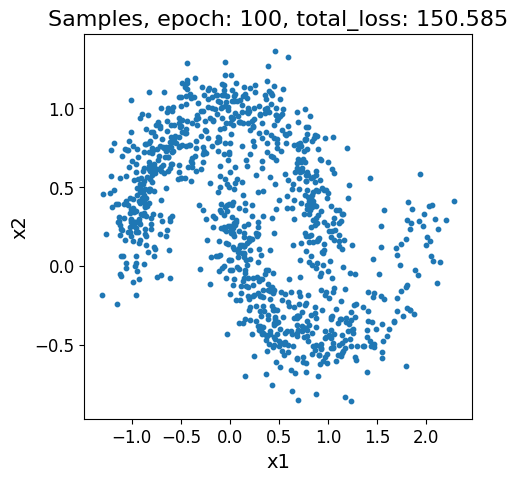

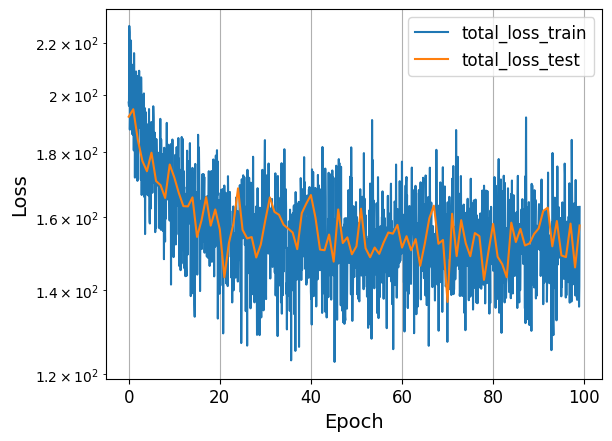

End of the training


In [45]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 256
EPOCHS = 100
LR = 1e-3
HIDDEN_SIZE = 256
SIGMA = 0.1
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

# ====
# your code
# define sequential model
# it is enough to use the sequence of Linear layers with activations

score_model = nn.Sequential(
    nn.Linear(2, HIDDEN_SIZE),
    nn.SiLU(),
    nn.LayerNorm(HIDDEN_SIZE),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.SiLU(),
    nn.LayerNorm(HIDDEN_SIZE),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.SiLU(),
    nn.LayerNorm(HIDDEN_SIZE),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.SiLU(),
    nn.LayerNorm(HIDDEN_SIZE),
    nn.Linear(HIDDEN_SIZE, 2),
)

# ====
matcher = DenoisingScoreMatcher(
    score_model=score_model, input_shape=(2,), sigma=SIGMA
)

# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(matcher.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

train_model(
    matcher,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    n_samples=1024,
    visualize_samples=True,
    logscale_y=True,
)

Let sample from our model. Experiment with number of steps and $\eta$ for Langevin dynamics.

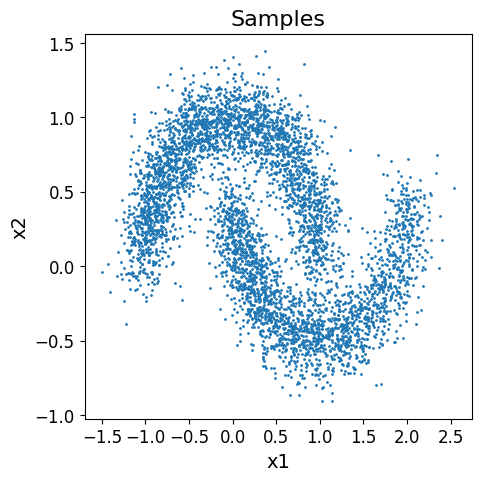

In [46]:
# ====
# your code
# choose these parameters
NUM_STEPS = 2000
ETA = 1e-3
# ====

samples = matcher.sample(num_samples=5000, num_steps=NUM_STEPS, eta=ETA).cpu()

visualize_2d_samples(samples, title="Samples", s=1)

## Noise Conditioned Score Network for MNIST

Now we try to extend our model to the NCSN. It means that we have to add multiple noise scales.

**Note!** Here we rescale the images to $[-1, 1]$, which will help us with training of the NCSN.

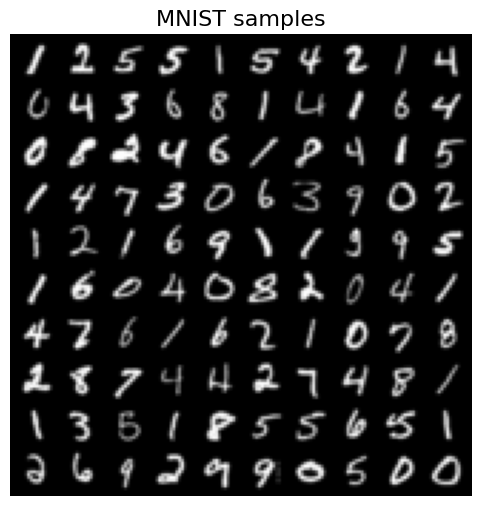

In [3]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=False)
visualize_images(train_data, "MNIST samples")

train_data, test_data = 2 * train_data - 1, 2 * test_data - 1


First, we'll define the UNet's core component. It is the `ResBlock`, which enhances standard ResNet blocks with timestep embeddings.

In [4]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_dim, dropout):
        super().__init__()

        self.temb_proj = nn.Sequential(nn.SiLU(), nn.Linear(t_dim, out_channels))

        # ====
        # your code
        # create two convolutional blocks of nn.Sequential
        # first block should take raw input
        # second block should take the output of the first block with added time and class embeddings
        # it is preferrable to use nn.GroupNorm (~8 groups), nn.SiLU and nn.Dropout

        def _num_groups(c: int) -> int:
            g = min(8, c)
            while g > 1 and (c % g) != 0:
                g -= 1
            return max(g, 1)

        self.block1 = nn.Sequential(
            nn.GroupNorm(_num_groups(in_channels), in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(_num_groups(out_channels), out_channels),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        )

        # ====

        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, temb):
        # ====
        # your code
        # 1) pass x through the first block
        # 2) add time embedding (unsqueeze it to the right shape)
        # 3) pass the result through the second block
        # 4) add the shortcut

        h = self.block1(x)
        h = h + self.temb_proj(temb).unsqueeze(-1).unsqueeze(-1)
        h = self.block2(h)
        h = h + self.shortcut(x)

        # ====
        return h

The `DownsampleBlock` and `UpsampleBlock` implement the UNet's characteristic encoder-decoder structure, managing resolution changes as features flow through the network.

In [5]:
class DownsampleBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        # ====
        # your code
        # define convolutional layer that:
        # 1) does not change the number of channels
        # 2) reduces the size of the image twice

        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)

        # ====

    def forward(self, input_tensor: torch.Tensor, *args) -> torch.Tensor:
        # ====
        # your code

        x = self.conv(input_tensor)

        # ====
        return x

class UpsampleBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        # ====
        # your code
        # define convolutional layer that:
        # 1) does not change the number of channels
        # 2) does not reduce the size of the image

        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

        # ====

    def forward(self, input_tensor: torch.Tensor, *args) -> torch.Tensor:
        # ====
        # your code
        # 1) upsample the input tensor using bilinear interpolation
        # 2) pass the result through the convolutional layer

        x = F.interpolate(input_tensor, scale_factor=2.0, mode="bilinear", align_corners=False)
        x = self.conv(x)

        # ====
        return x

Finally, we define the complete `UNet` - the neural network backbone of our diffusion model that handles both encoding and decoding with skip connections. Look at the code carefully.

In [6]:
class UNet(nn.Module):
    def __init__(
        self,
        num_timesteps: int,
        hidden_channels: int,
        channel_multipliers: List[int],
        num_blocks: int = 1,
        dropout: float = 0.1
    ):
        super().__init__()

        temb_dim = hidden_channels * 4
        self.time_embedding = nn.Embedding(num_timesteps, temb_dim)
        self.head = nn.Conv2d(1, hidden_channels, kernel_size=3, stride=1, padding=1)
        channel_list, curr_channels = [hidden_channels], hidden_channels

        # initialization of downsample blocks
        self.downsample_blocks = nn.ModuleList()
        for idx, scale in enumerate(channel_multipliers):
            out_channels = hidden_channels * scale
            is_last = (idx == len(channel_multipliers) - 1)

            # make multiple ResBlocks at each scale
            for _ in range(num_blocks):
                # at each channel_multipliers scale we add ResBlock
                # last block has attention
                self.downsample_blocks.append(
                    ResBlock(curr_channels, out_channels, temb_dim, dropout)
                )
                curr_channels = out_channels
                channel_list.append(curr_channels)

            # add downsample block if not last block
            if not is_last:
                self.downsample_blocks.append(DownsampleBlock(curr_channels))
                channel_list.append(curr_channels)

        # initialization of bottleneck block
        self.bottleneck = nn.ModuleList([
            ResBlock(curr_channels, curr_channels, temb_dim, dropout),
            ResBlock(curr_channels, curr_channels, temb_dim, dropout)
        ])

        # initialization of upsample blocks
        self.upsample_blocks = nn.ModuleList()
        for idx, scale in reversed(list(enumerate(channel_multipliers))):
            out_channels = hidden_channels * scale
            is_first, is_last = (idx == 0), (idx == len(channel_multipliers) - 1)

            # make multiple ResBlocks at each scale
            for _ in range(num_blocks + 1):
                # at each reverse channel_multipliers scale we add ResBlock
                # first block has attention
                self.upsample_blocks.append(
                    ResBlock(channel_list.pop() + curr_channels, out_channels, temb_dim, dropout)
                )

                curr_channels = out_channels

            # add upsample block if not last block
            if not is_first:
                self.upsample_blocks.append(UpsampleBlock(curr_channels))

        self.tail = nn.Sequential(
            nn.GroupNorm(8, curr_channels),
            nn.SiLU(),
            nn.Conv2d(curr_channels, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x, t):
        temb = self.time_embedding(t)

        h = self.head(x)
        skip_connections = [h] # save intermediate results for skip connections

        # downsample
        for layer in self.downsample_blocks:
            h = layer(h, temb)
            skip_connections.append(h) # save intermediate results for skip connections

        # bottleneck
        for layer in self.bottleneck:
            h = layer(h, temb)

        # upsample
        for layer in self.upsample_blocks:
            if isinstance(layer, ResBlock): # apply skip connection
                skip_connection = skip_connections.pop()
                h = torch.cat([h, skip_connection], dim=1)
            h = layer(h, temb)

        h = self.tail(h)
        return h

def test_unet():
    model = UNet(
        num_timesteps=10,
        hidden_channels=128,
        channel_multipliers=[1, 2],
        num_blocks=2
    )
    x = torch.rand((2, 1, 14, 14))
    t = torch.zeros(size=(2,), dtype=torch.long)
    out1 = model(x, t)
    t = torch.ones(size=(2,), dtype=torch.long)
    out2 = model(x, t)
    assert not np.allclose(out1.detach().numpy(), out2.detach().numpy())


test_unet()

Now lets define the main model.

We will use the sequence of the noise levels: $\sigma_1 < \sigma_2 < \dots < \sigma_T$. In this task it will be the geometric progression.
And we will perturb the original data with the different noise levels to obtain
$$
\mathbf{x}_t = \mathbf{x} + \sigma_t \cdot \boldsymbol{\epsilon}, \quad \mathbf{x}_t \sim q(\mathbf{x}_t).
$$

Our training objective:
$$
    \sum_{t=1}^T \frac{\sigma_t^2}{\sigma_T^2} \mathbb{E}_{\pi(\mathbf{x})} \mathbb{E}_{q(\mathbf{x}_t | \mathbf{x})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma_t}(\mathbf{x}_t) - \nabla_{\mathbf{x}_{\sigma}} \log q(\mathbf{x}_t | \mathbf{x}) \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}
$$
But instead of doing the honest summation we will sample one timestamp for each sample.

We will use annealed Langevin dynamics to sample from our model:
1. Sample $\mathbf{x}_0 \sim \mathcal{N}(0, \sigma_T^2 \cdot \mathbf{I}) \approx q(\mathbf{x}_T)$.
2. Apply $L$ steps of Langevin dynamic
$$
    \mathbf{x}_l = \mathbf{x}_{l-1} + \frac{\eta_t}{2} \cdot \mathbf{s}_{\boldsymbol{\theta}, \sigma_t}(\mathbf{x}_{l - 1}) + \sqrt{\eta_t} \cdot \boldsymbol{\epsilon}_l.
$$
3. Update $\mathbf{x}_0 := \mathbf{x}_L$ and choose the next $\sigma_t$.
4. Repeat it for all sigmas.

**Note:** use the following formula for $\eta_t = \epsilon \cdot \frac{\sigma_t^2}{\sigma_T^2}$ ($\epsilon$ is a small number that is a hyperparameter of the sampling).

In [7]:
class NoiseConditionedScoreNetwork(BaseModel):
    def __init__(
            self,
            input_shape: Tuple[int, int],
            sigmas: List[float],
            hidden_channels: int,
            channel_multipliers: List[int],
            num_blocks: int
        ):
        super().__init__()

        self.score_model = UNet(
            num_timesteps=len(sigmas),
            hidden_channels=hidden_channels,
            channel_multipliers=channel_multipliers,
            num_blocks=num_blocks
        )
        self.input_shape = input_shape
        self.sigmas = torch.FloatTensor(sorted(sigmas, reverse=True))

    def forward(self, x: torch.Tensor):
        self.sigmas = self.sigmas.to(self.device)
        batch_size = x.shape[0]
        # ====
        # your code
        # sample gaussian noise
        # sample timestamps for each datapoint in the batch
        # choose sigmas for these datapoints
        # add noises to the x samples

        eps = torch.randn_like(x)
        which_sigmas = torch.randint(
            low=0,
            high=len(self.sigmas),
            size=(batch_size,),
            device=x.device,
            dtype=torch.long
        )
        used_sigmas = self.sigmas[which_sigmas].view(batch_size, 1, 1, 1)
        noisy_x = x + used_sigmas * eps

        # =====

        # calculate the score model
        s = self.score_model(noisy_x, which_sigmas)

        # ====
        # your code
        # compute the loss
        # it is mse between score function and gradient of the normal distribution (do not forget the coefficient before the mse)

        target = -eps / used_sigmas
        coef = (used_sigmas ** 2) / (self.sigmas[0] ** 2)
        loss = coef * (s - target) ** 2

        # =====
        return loss

    def loss(self, x: torch.Tensor):
        return {"total_loss": self(x).mean(dim=0).sum()}

    def annealed_langevin_dynamics(self, x: torch.Tensor, num_steps: int, eps: float):
        # =====
        # your code
        # here we will have 2 cycles: one for sigmas, one for Langevin sampling
        # start with the largest sigma, apply Langevin dynamic for it and move to the next sigma

        self.sigmas = self.sigmas.to(self.device)
        sigma_max_sq = self.sigmas[0] ** 2
        batch_size = x.shape[0]

        for t_idx, sigma in enumerate(self.sigmas):
            eta_t = eps * (sigma ** 2) / sigma_max_sq
            t = torch.full((batch_size,), t_idx, device=x.device, dtype=torch.long)

            for _ in range(int(num_steps)):
                z = torch.randn_like(x)
                s = self.score_model(x, t)
                x = x + 0.5 * eta_t * s + torch.sqrt(eta_t) * z

        # =====
        return x

    @torch.no_grad()
    def sample(self, num_samples: int = 64, num_steps: int=10, eps: float = 0.1):
        # we sample x_0 from U[-1, 1]
        x0 = 2. * torch.rand_like(torch.empty(num_samples, *self.input_shape)) - 1.
        x0 = x0.to(self.device)

        # run langevine dynamics
        x = self.annealed_langevin_dynamics(x0, num_steps=num_steps, eps=eps)
        return (x.clip(-1., 1) + 1) / 2


def test_ncsn():
    ncsn = NoiseConditionedScoreNetwork(
        input_shape=(1, 8, 8),
        sigmas=[0.1],
        hidden_channels=64,
        channel_multipliers=[1, 2],
        num_blocks=1
    )
    x = torch.rand((2, 1, 8, 8))
    assert x.size() == ncsn(x).size()
    loss = ncsn.loss(x)["total_loss"]
    assert len(loss.size()) == 0
    assert list(ncsn.sample(4).size()) == [4, 1, 8, 8]


test_ncsn()

Epoch: 20, loss: 32.17345877852775


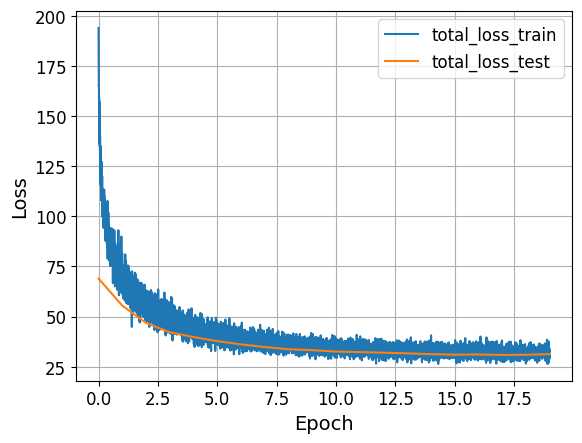

End of the training


In [8]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 128
LR = 2e-4
EPOCHS = 20
HIDDEN_CHANNELS = 64
CHANNEL_MULTIPLIERS = [1, 2]
NUM_BLOCKS = 2

sigma_max = 1.0
sigma_min = 0.01
L = 10
SIGMAS = list(np.geomspace(sigma_min, sigma_max, L))
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

ncsn = NoiseConditionedScoreNetwork(
    input_shape=(1, 14, 14), sigmas=SIGMAS,
    hidden_channels=HIDDEN_CHANNELS,
    channel_multipliers=CHANNEL_MULTIPLIERS,
    num_blocks=NUM_BLOCKS
)

# choose any optimizer/scheduler as you want
optimizer = torch.optim.AdamW(ncsn.parameters(), lr=LR, betas=(0.9, 0.999), weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# train
train_model(
    ncsn,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    n_samples=16,
    visualize_samples=False # probably you don't want to visualize samples, since it takes a lot of time
)

Now you can try to select proper inference parameters to obtain better images.

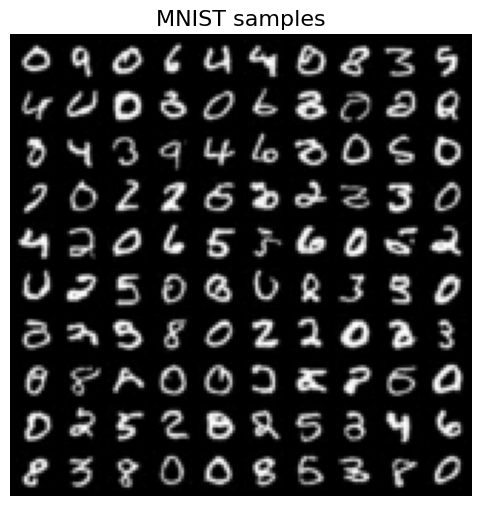

In [9]:
# ====
# your code
# choose these parameters
NUM_STEPS = 100
EPS = 0.05
# ====

samples = ncsn.sample(100, num_steps=NUM_STEPS, eps=EPS).cpu()
show_samples(samples, "MNIST samples")